In [ ]:

#Libraries for data cleaning and visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import dask.dataframe as dd
import pyarrow.parquet as pq
import fastparquet


#Import libraries for visualization and charts
import seaborn as sns
import matplotlib.pyplot as plt

# These are windows OS talking libraries
import os
import warnings
warnings.filterwarnings('ignore')
import statistics
import math
from datetime import datetime

#Liraries for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats, integrate
import scipy.stats as stats
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


#This is to dislay limited info on Jupyter preview
pd.set_option('display.max_colwidth',1000)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import pandas as pd
import dask
import dask.dataframe as dd
import folium
from folium.plugins import HeatMap

print(f"Pandas version: {pd.__version__}")
print(f"Dask version: {dask.__version__}")

C:\Users\pvp373\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\pvp373\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Pandas version: 2.2.2
Dask version: 2024.8.0


In [2]:
os.chdir('D:\\NYC Trip Data')

In [ ]:
import pandas as pd
import os

# Initialize an empty DataFrame
df_test = pd.DataFrame()

# File path for December 2023
file_path = 'D:\\NYC Trip Data\\archive\\2023\\fhvhv_tripdata_2023-09.PARQUET'

# Check if the file exists
if os.path.exists(file_path):
    # Load the data for the specific file
    df_temp = pd.read_parquet(file_path)
    
    # Convert pickup date column to datetime (replace 'pickup_datetime' with the correct column name)
    df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime'])
    
    # Filter for trips between December 23 and December 31, 2023
    start_date = '2023-09-15'
    end_date = '2023-09-30'
    df_test = df_temp[(df_temp['pickup_datetime'] >= start_date) & (df_temp['pickup_datetime'] <= end_date)]
    
    print(f"Loaded data for trips between {start_date} and {end_date}.")
else:
    print(f"File not found: {file_path}")

# Optional: Save filtered data to a new file
df_test.to_csv("filtered_trips_sept_2023.csv", index=False)

# Display a preview of the filtered data
print(df_test.shape)


In [3]:
# Read the saved Parquet file back into a Dask DataFrame
df_test = pd.read_csv('filtered_trips_sept_2023.csv')


In [4]:
# Ensure columns are converted to object type for flexibility
df_test['hvfhs_license_num'] = df_test['hvfhs_license_num'].astype('object')
df_test['shared_request_flag'] = df_test['shared_request_flag'].astype('object')
df_test['shared_match_flag'] = df_test['shared_match_flag'].astype('object')
df_test['access_a_ride_flag'] = df_test['access_a_ride_flag'].astype('object')
df_test['wav_request_flag'] = df_test['wav_request_flag'].astype('object')
df_test['wav_match_flag'] = df_test['wav_match_flag'].astype('object')

# Perform replacement using Pandas' replace method
df_test['hvfhs_license_num'] = df_test['hvfhs_license_num'].replace({
    "HV0003": "Uber",
    "HV0005": "Lyft"
})


In [5]:
# Fill missing values with 'N' and replace 'Y' with 1 and 'N' with 0
df_test['shared_request_flag'] = df_test['shared_request_flag'].fillna('N').replace({'Y': 1, 'N': 0})
df_test['shared_match_flag'] = df_test['shared_match_flag'].fillna('N').replace({'Y': 1, 'N': 0})
df_test['access_a_ride_flag'] = df_test['access_a_ride_flag'].fillna('N').replace({'Y': 1, 'N': 0})
df_test['wav_request_flag'] = df_test['wav_request_flag'].fillna('N').replace({'Y': 1, 'N': 0})
df_test['wav_match_flag'] = df_test['wav_match_flag'].fillna('N').replace({'Y': 1, 'N': 0})

# Create congestion_surcharge_Flag: 1 if congestion_surcharge > 0, else 0
df_test['congestion_surcharge_Flag'] = (df_test['congestion_surcharge'] > 0).astype(int)


In [6]:
# Load the zone lookup CSV files once and add suffixes for pickup (PU) and dropoff (DU)
df_zones_PU = pd.read_csv('D:\\NYC Trip Data\\archive\\taxi_zones\\taxi+_zone_lookup.csv').add_suffix('_PU')
df_zones_DU = pd.read_csv('D:\\NYC Trip Data\\archive\\taxi_zones\\taxi+_zone_lookup.csv').add_suffix('_DU')

# Perform merges with Pandas' merge
df_test = pd.merge(df_test, df_zones_PU, left_on='PULocationID', right_on='LocationID_PU', how='left')
df_test = pd.merge(df_test, df_zones_DU, left_on='DOLocationID', right_on='LocationID_DU', how='left')


In [7]:
# Convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime data type using Dask's `to_datetime`
df_test['pickup_time'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['dropoff_time'] = pd.to_datetime(df_test['dropoff_datetime'])

In [8]:
import pandas as pd

# Ensure all datetime columns are in datetime format
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], errors='coerce')
df_test['dropoff_time'] = pd.to_datetime(df_test['dropoff_time'], errors='coerce')
df_test['pickup_time'] = pd.to_datetime(df_test['pickup_time'], errors='coerce')
df_test['request_datetime'] = pd.to_datetime(df_test['request_datetime'], errors='coerce')

# Calculate trip duration in minutes
df_test['trip_duration'] = (df_test['dropoff_time'] - df_test['pickup_time']).dt.total_seconds() / 60

# Calculate 'tnc_wait_time' in minutes (difference between pickup_time and request_datetime)
df_test['tnc_wait_time'] = (df_test['pickup_time'] - df_test['request_datetime']).dt.total_seconds() / 60

# Extract pickup month from 'pickup_datetime'
df_test['pickup_month'] = df_test['pickup_datetime'].dt.month

# Extract pickup hour, pickup date, and day name
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test['pickup_date'] = df_test['pickup_datetime'].dt.date
df_test['pickup_day_name'] = df_test['pickup_datetime'].dt.day_name()

# Define the function to map hours to day periods
def hour_to_daytime(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Midnight'

# Create a new column 'Daytime' by applying the function
df_test['Daytime'] = df_test['pickup_hour'].apply(hour_to_daytime)

# Display first few rows to verify
print(df_test.head())


  hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

     request_datetime    on_scene_datetime     pickup_datetime  \
0 2023-09-15 00:20:35                  NaN 2023-09-15 00:22:35   
1 2023-09-15 00:17:56  2023-09-15 00:19:30 2023-09-15 00:21:05   
2 2023-09-15 00:39:08  2023-09-15 00:42:10 2023-09-15 00:42:29   
3 2023-09-15 00:52:24  2023-09-15 00:54:58 2023-09-15 00:55:17   
4 2023-09-15 00:48:53  2023-09-15 00:51:54 2023-09-15 00:52:52   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231            35       7.354       1892   
1  2023-09-15 00:33:30           235            78       1

In [9]:
# Calculate pickup hour, day of the week, and date from pickup datetime

df_test['pickup_day_of_week'] = df_test['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Ensure 'pickup_day' is created by extracting the day name from 'pickup_datetime'
df_test['pickup_day'] = df_test['pickup_datetime'].dt.day_name()

# Calculate pickup hour, day of the week, and date from pickup datetime
df_test['pickup_day_of_week'] = df_test['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Create one-hot encoding for months using vectorized operations
df_test['Jan'] = (df_test['pickup_month'] == 1).astype(int)
df_test['Feb'] = (df_test['pickup_month'] == 2).astype(int)
df_test['Mar'] = (df_test['pickup_month'] == 3).astype(int)
df_test['April'] = (df_test['pickup_month'] == 4).astype(int)
df_test['May'] = (df_test['pickup_month'] == 5).astype(int)
df_test['June'] = (df_test['pickup_month'] == 6).astype(int)
df_test['July'] = (df_test['pickup_month'] == 7).astype(int)
df_test['Aug'] = (df_test['pickup_month'] == 8).astype(int)
df_test['Sept'] = (df_test['pickup_month'] == 9).astype(int)
df_test['Oct'] = (df_test['pickup_month'] == 10).astype(int)
df_test['Nov'] = (df_test['pickup_month'] == 11).astype(int)
df_test['Dec'] = (df_test['pickup_month'] == 12).astype(int)

# Create one-hot encoding for days of the week using vectorized operations
df_test['Monday'] = (df_test['pickup_day'] == 'Monday').astype(int)
df_test['Tuesday'] = (df_test['pickup_day'] == 'Tuesday').astype(int)
df_test['Wednesday'] = (df_test['pickup_day'] == 'Wednesday').astype(int)
df_test['Thursday'] = (df_test['pickup_day'] == 'Thursday').astype(int)
df_test['Friday'] = (df_test['pickup_day'] == 'Friday').astype(int)
df_test['Saturday'] = (df_test['pickup_day'] == 'Saturday').astype(int)
df_test['Sunday'] = (df_test['pickup_day'] == 'Sunday').astype(int)

# Create one-hot encoding for Daytime using vectorized operations
df_test['Morning'] = (df_test['Daytime'] == 'Morning').astype(int)
df_test['Afternoon'] = (df_test['Daytime'] == 'Afternoon').astype(int)
df_test['Evening'] = (df_test['Daytime'] == 'Evening').astype(int)
df_test['Midnight'] = (df_test['Daytime'] == 'Midnight').astype(int)

In [10]:
# Perform fare calculations using NumPy's vectorized maximum function
df_test['uberx_basefare'] = np.maximum(2.55 + df_test['trip_miles'] * 1.75 + 0.35 * df_test['trip_duration'], 7)
df_test['uberXL_basefare'] = np.maximum(3.85 + df_test['trip_miles'] * 2.85 + 0.5 * df_test['trip_duration'], 10.5)
df_test['uberBlack_basefare'] = np.maximum(7 + df_test['trip_miles'] * 3.75 + 0.65 * df_test['trip_duration'], 15)
df_test['uberSUV_basefare'] = np.maximum(14 + df_test['trip_miles'] * 4.5 + 0.8 * df_test['trip_duration'], 25)

# Perform fare calculations using NumPy's vectorized maximum function
df_test['lyft_basefare'] = np.maximum(0 + df_test['trip_miles'] * 1.82 + 0.78 * df_test['trip_duration'], 7.3)
df_test['lyftXL_basefare'] = np.maximum(0 + df_test['trip_miles'] * 2.49 + 0.93 * df_test['trip_duration'], 9.43)
df_test['lyftExComf_basefare'] = np.maximum(0 + df_test['trip_miles'] * 2.24 + 0.84 * df_test['trip_duration'], 15)
df_test['lyftBlack_basefare'] = np.maximum(0 + df_test['trip_miles'] * 2.86 + 0.88 * df_test['trip_duration'], 13.47)
df_test['lyftBlackXL_basefare'] = np.maximum(0 + df_test['trip_miles'] * 4.04 + 1.19 * df_test['trip_duration'], 22.45)

In [11]:
# Create a column called 'Serial Number' based on the row index
df_test['Serial Number'] = df_test.reset_index().index + 1

In [12]:
df_test.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

     request_datetime    on_scene_datetime     pickup_datetime  \
0 2023-09-15 00:20:35                  NaN 2023-09-15 00:22:35   
1 2023-09-15 00:17:56  2023-09-15 00:19:30 2023-09-15 00:21:05   
2 2023-09-15 00:39:08  2023-09-15 00:42:10 2023-09-15 00:42:29   
3 2023-09-15 00:52:24  2023-09-15 00:54:58 2023-09-15 00:55:17   
4 2023-09-15 00:48:53  2023-09-15 00:51:54 2023-09-15 00:52:52   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231            35       7.354       1892   
1  2023-09-15 00:33:30           235            78       1.780        745   
2  2023-09-15 00:51:21           169            47       1.300        532   
3  2023-09-15 01:12:05            60           168       4.850       1008   
4  2023-09-15 01:08:00            45           249       2.430        908   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                10.68    0.0  0.29       0.95                  0.00   
2                 9.02    0.0  0.25       0.80                  0.00   
3                16.07    0.0  0.44       1.43                  0.00   
4                18.33    0.0  0.50       1.63                  2.75   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        6.81                    0                  0   
3          0.0   0.0       15.95                    0                  0   
4          0.0   0.0       15.20                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                  0                 0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               1   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          1            231  Manhattan   
1                          0            235      Bronx   
2                          0            169      Bronx   
3                          0             60      Bronx   
4                          1             45  Manhattan   

                             Zone_PU service_zone_PU  LocationID_DU  \
0               TriBeCa/Civic Center     Yellow Zone             35   
1  University Heights/Morris Heights       Boro Zone             78   
2                         Mount Hope       Boro Zone             47   
3                  Crotona Park East       Boro Zone            168   
4                          Chinatown     Yellow Zone            249   

  Borough_DU                 Zone_DU service_zone_DU         pickup_time  \
0   Brooklyn             Brownsville       Boro Zone 2023-09-15 00:22:35   
1      Bronx            East Tremont       Boro Zone 2023-09-15 00:21:05   
2      Bronx      Claremont/Bathgate       Boro Zone 2023-09-15 00:42:29   
3      Bronx  Mott Haven/Port Morris       Boro Zone 2023-09-15 00:55:17   
4  Manhattan            West Village     Yellow Zone 2023-09-15 00:52:52   

         dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0 2023-09-15 00:54:07      31.533333       2.000000             9   
1 2023-09-15 00:33:30      12.416667       3.150000             9   
2 2023-09-15 00:51:21       8.866667       3.350000             9   
3 2

Original CRS: EPSG:2263


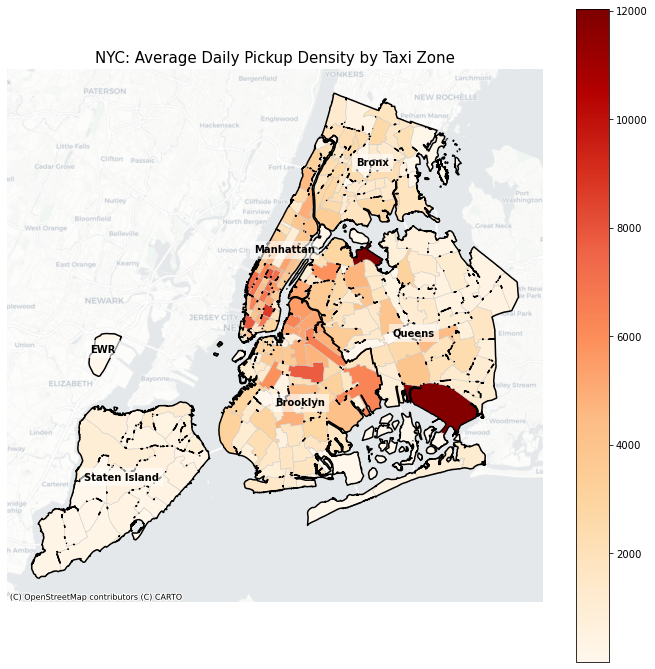

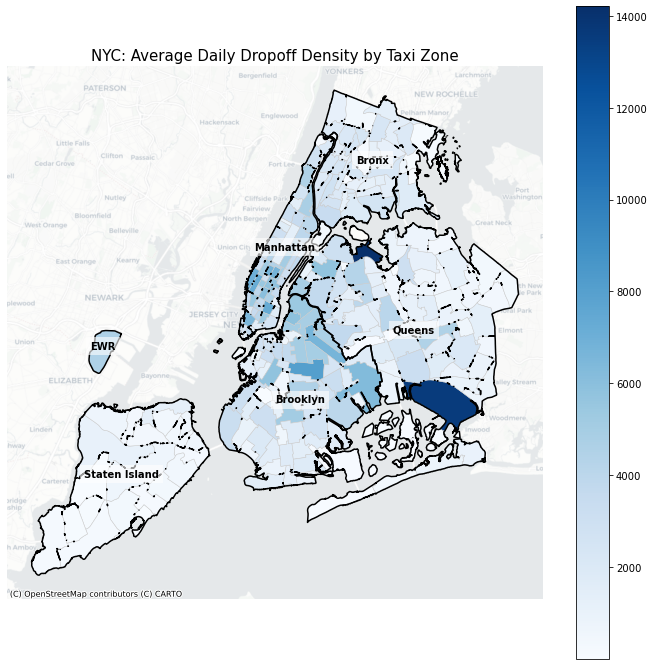

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily for basemap

# ✅ Step 1: Load NYC Taxi Zones Shapefile
gdf_zones = gpd.read_file("D:\\NYC Trip Data\\taxi_zones\\taxi_zones.shp")

# ✅ Step 2: Convert to Correct CRS for Map Overlay
print("Original CRS:", gdf_zones.crs)
gdf_zones = gdf_zones.to_crs(epsg=3857)  # Convert to Web Mercator for map compatibility

# ✅ Step 3: Prepare Pickup and Dropoff Data
df_trips = df_test  # Ensure df_test is your trip dataset

# Convert trip date to datetime
df_trips['date'] = pd.to_datetime(df_trips['request_datetime']).dt.date

# Aggregate daily pickups and dropoffs
pickup_daily = df_trips.groupby(['date', 'PULocationID', 'Borough_PU']).size().reset_index(name='pickup_count')
dropoff_daily = df_trips.groupby(['date', 'DOLocationID', 'Borough_DU']).size().reset_index(name='dropoff_count')

# ✅ Step 4: Merge Data with Taxi Zone Shapefile
gdf_zones_pickup = gdf_zones.rename(columns={'OBJECTID': 'PULocationID'})  
gdf_pickups = gdf_zones_pickup.merge(
    pickup_daily.groupby(['PULocationID', 'Borough_PU'])['pickup_count'].mean().reset_index(),
    on='PULocationID', 
    how='left'
)

gdf_zones_dropoff = gdf_zones.rename(columns={'OBJECTID': 'DOLocationID'})  
gdf_dropoffs = gdf_zones_dropoff.merge(
    dropoff_daily.groupby(['DOLocationID', 'Borough_DU'])['dropoff_count'].mean().reset_index(),
    on='DOLocationID', 
    how='left'
)

# ✅ Step 5: Create Borough Boundaries
borough_boundaries = gdf_zones_pickup.dissolve(by='borough')

# ✅ Step 6: Plot NYC Pickup Density Map with Basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot taxi zones with pickup counts
gdf_pickups.plot(column='pickup_count', cmap='OrRd', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)

# Overlay borough boundaries
borough_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

# Add NYC Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.6)

# Add borough names
for idx, row in borough_boundaries.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, s=idx, fontsize=10, fontweight='bold', ha='center', 
            color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title('NYC: Average Daily Pickup Density by Taxi Zone', fontsize=15)
ax.set_axis_off()
plt.show()

# ✅ Step 7: Plot NYC Dropoff Density Map with Basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot taxi zones with dropoff counts
gdf_dropoffs.plot(column='dropoff_count', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)

# Overlay borough boundaries
borough_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

# Add NYC Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.6)

# Add borough names
for idx, row in borough_boundaries.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, s=idx, fontsize=10, fontweight='bold', ha='center', 
            color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title('NYC: Average Daily Dropoff Density by Taxi Zone', fontsize=15)
ax.set_axis_off()
plt.show()


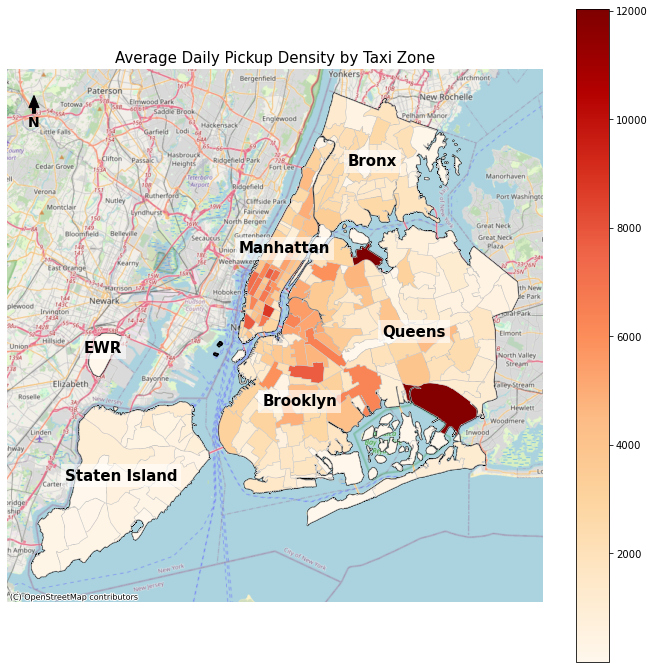

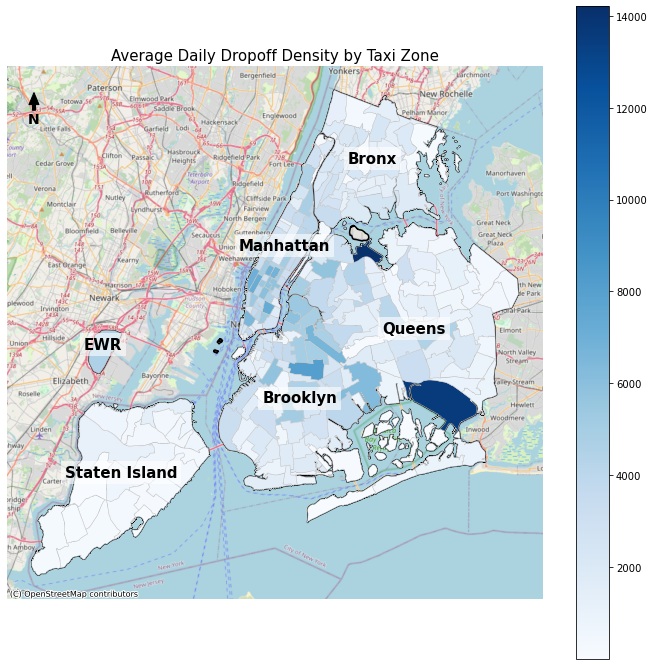

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import xyzservices.providers as xyz

# ✅ Step 1: Load NYC Taxi Zone Shapefile
gdf_zones = gpd.read_file("D:\\NYC Trip Data\\taxi_zones\\taxi_zones.shp")

# Define a helper function to add a north arrow
def add_north_arrow(ax, x=0.1, y=0.9, arrow_length=0.05):
    """
    Adds a north arrow to the given axes (ax).
    
    Parameters:
    - ax: Matplotlib axes on which to draw the arrow.
    - x, y: The location of the arrow in 'axes fraction' coordinates (0 to 1).
    - arrow_length: How long the arrow should be in those same coordinates.
    """
    ax.annotate(
        'N', 
        xy=(x, y), 
        xytext=(x, y - arrow_length),
        xycoords='axes fraction',
        textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width=3, headwidth=10),
        ha='center', 
        va='center', 
        fontsize=14, 
        fontweight='bold'
    )

# ... [Your data preparation code above] ...

# Make sure all your GeoDataFrames are in EPSG:3857
gdf_pickups = gdf_pickups.to_crs(epsg=3857)
gdf_dropoffs = gdf_dropoffs.to_crs(epsg=3857)
borough_boundaries = borough_boundaries.to_crs(epsg=3857)

# ---------------------------
# Plotting the Pickup Density Map with a Basemap
# ---------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot borough boundaries as the base layer
borough_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

# Overlay the taxi zone pickup density map
gdf_pickups.plot(
    column='pickup_count', 
    cmap='OrRd', 
    linewidth=0.5,
    ax=ax, 
    edgecolor='0.8', 
    legend=True
)

# Add borough names at the centroid of each boundary
for idx, row in borough_boundaries.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        s=idx, 
        fontsize=15, 
        fontweight='bold',
        ha='center', 
        color='black', 
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Add a basemap using a known provider, e.g. OpenStreetMap
ctx.add_basemap(ax, source=xyz.OpenStreetMap.Mapnik)

# Add the north arrow
add_north_arrow(ax, x=0.05, y=0.95, arrow_length=0.05)

plt.title('Average Daily Pickup Density by Taxi Zone', fontsize=15)
ax.set_axis_off()  # Hide x and y axes
plt.show()

# ---------------------------
# Plotting the Dropoff Density Map with a Basemap
# ---------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

borough_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

gdf_dropoffs.plot(
    column='dropoff_count', 
    cmap='Blues', 
    linewidth=0.5,
    ax=ax, 
    edgecolor='0.8', 
    legend=True
)

for idx, row in borough_boundaries.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        s=idx, 
        fontsize=15, 
        fontweight='bold',
        ha='center', 
        color='black', 
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Add the same basemap
ctx.add_basemap(ax, source=xyz.OpenStreetMap.Mapnik)

# Add the north arrow
add_north_arrow(ax, x=0.05, y=0.95, arrow_length=0.05)

plt.title('Average Daily Dropoff Density by Taxi Zone', fontsize=15)
ax.set_axis_off()
plt.show()


In [17]:
gdf_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough  \
0            EWR   
1         Queens   
2          Bronx   
3      Manhattan   
4  Staten Island   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  geometry  
0  POLYGON ((933100.918 192536.086, 933091.011 192572.175, 933088.585 192604.970, 933121.560 192857.382, 933149.268 192978.645, 933222.304 193293.273, 933252.582 193450.600, 933297.723 193555.433, 933330.571 193748.823, 933350.632 193794.687, 933355.706 193834.024, 933365.798 193886.466, 933431.739 194391.291, 933465.038 194801.093, 933463.434 195227.363, 933471.105 195315.879, 933483.754 195397.827, 933511.436 195509.255, 933554.091 195620.651, 933609.194 195718.905, 933669.247 195797.475, 933731.775 195866.204, 933779.276 195908.732, 933841.762 195957.786, 933906.723 195996.999, 933976.674 196036.202, 934119.044 196101.488, 934491.267 196304.019, 934656.105 196375.819, 934810.948 196441.083, 934963.289 196503.074, 935150.582 196574.832, 935178.064 196591.171, 935205.551 196610.790, 935273.090 196692.628, 935335.676 196794.150, 935373.251 196866.212, 935430.800 196944.791, 935455.812 196974.252, 935483.312 197000.429, 935548.274 197042.925, 935625.692 197075.560, 935688.106 197091.83...  
1  MULTIPOLYGON (((1033269.244 172126.008, 1033439.643 170883.946, 1033473.265 170808.208, 1033504.660 170731.521, 1033533.803 170653.949, 1033560.667 170575.560, 1033585.230 170496.419, 1033607.472 170416.594, 1033627.372 170336.154, 1033644.914 170255.167, 1033660.084 170173.702, 1033672.867 170091.829, 1033683.254 170009.618, 1033691.235 169927.138, 1033696.804 169844.460, 1033699.956 169761.655, 1033700.687 169678.793, 1033698.999 169595.945, 1033914.712 168756.095, 1033987.383 168631.157, 1034049.614 168461.429, 1034152.071 168286.528, 1034190.853 168220.321, 1034215.168 168143.684, 1034239.479 168067.044, 1034288.511 168020.384, 1034359.472 167990.046, 1034780.204 167800.349, 1034768.641 167571.082, 1034854.960 167383.735, 1035019.891 167173.945, 1035295.456 166890.275, 1035303.561 166784.912, 1035149.634 166644.979, 1035125.254 166622.815, 1034785.622 166702.902, 1034518.710 166336.924, 1034525.495 166168.944, 1034703.802 165974.427, 1034833.479 165917.694, 1034833.479 165804.2...  
2  POLYGON ((1026308.770 256767.698, 1026495.593 256638.616, 1026567.230 256589.859, 1026729.235 256481.356, 1026817.315 256421.566, 1026902.630 256362.665, 1027071.239 256248.925, 1027152.980 256192.892, 1027279.263 256106.327, 1027331.842 256069.276, 1027510.630 255948.374, 1027629.334 255866.839, 1027727.008 255800.518, 1027837.261 255725.658, 1027990.791 255622.893, 1028164.770 255501.600, 1028325.383 2

In [18]:
import geopandas as gpd

# Check the current CRS (Coordinate Reference System) of the shapefile
print("Current CRS:", gdf_zones.crs)

Current CRS: EPSG:2263


In [19]:
import geopandas as gpd

# Conversion factor: 1 square foot = 3.587e-8 square miles
feet_to_miles = 3.587e-8  

# Ensure the CRS is correct before calculating area
if gdf_zones.crs.to_epsg() == 2263:
    print("CRS is already in EPSG:2263 (New York State Plane), using square feet for area calculation.")
else:
    gdf_zones = gdf_zones.to_crs(epsg=2263)

# Calculate area in square feet
gdf_zones['area_sq_ft'] = gdf_zones.geometry.area

# Convert to square miles
gdf_zones['area_sq_miles'] = gdf_zones['area_sq_ft'] * feet_to_miles

# --- Compute Total Area of All Taxi Zones ---
total_taxi_zone_area_sq_miles = gdf_zones['area_sq_miles'].sum()
print(f"Total Area of All Taxi Zones: {total_taxi_zone_area_sq_miles:.2f} square miles")

# --- Compute Average Area of Boroughs ---
borough_avg_area_sq_miles = gdf_zones.groupby('borough')['area_sq_miles'].mean().reset_index()
borough_avg_area_sq_miles.columns = ['Borough', 'Average_Area_sq_miles']
print("\nAverage Area of Boroughs (in square miles):")
print(borough_avg_area_sq_miles)

# --- Compute Total Area of Each Borough ---
borough_total_area_sq_miles = gdf_zones.groupby('borough')['area_sq_miles'].sum().reset_index()
borough_total_area_sq_miles.columns = ['Borough', 'Total_Area_sq_miles']
print("\nTotal Area of Each Borough (in square miles):")
print(borough_total_area_sq_miles)



CRS is already in EPSG:2263 (New York State Plane), using square feet for area calculation.
Total Area of All Taxi Zones: 306.15 square miles

Average Area of Boroughs (in square miles):
         Borough  Average_Area_sq_miles
0          Bronx               0.990063
1       Brooklyn               1.115548
2            EWR               2.835148
3      Manhattan               0.329568
4         Queens               1.619179
5  Staten Island               2.911262

Total Area of Each Borough (in square miles):
         Borough  Total_Area_sq_miles
0          Bronx            42.572720
1       Brooklyn            68.048409
2            EWR             2.835148
3      Manhattan            22.740223
4         Queens           111.723334
5  Staten Island            58.225240


In [20]:
import pandas as pd

# Aggregate total pickups and dropoffs per borough
borough_pickups = df_trips.groupby('Borough_PU')['PULocationID'].count().reset_index(name='total_pickups')
borough_dropoffs = df_trips.groupby('Borough_DU')['DOLocationID'].count().reset_index(name='total_dropoffs')

# Compute total trips
total_pickups = borough_pickups['total_pickups'].sum()
total_dropoffs = borough_dropoffs['total_dropoffs'].sum()

# Compute percentages
borough_pickups['pickup_percentage'] = (borough_pickups['total_pickups'] / total_pickups) * 100
borough_dropoffs['dropoff_percentage'] = (borough_dropoffs['total_dropoffs'] / total_dropoffs) * 100

# Merge pickups and dropoffs data
borough_trips = pd.merge(borough_pickups, borough_dropoffs, left_on='Borough_PU', right_on='Borough_DU', how='outer')
borough_trips = borough_trips[['Borough_PU', 'total_pickups', 'pickup_percentage', 'total_dropoffs', 'dropoff_percentage']]
borough_trips.rename(columns={'Borough_PU': 'Borough'}, inplace=True)

# Display the result
from IPython.display import display
display(borough_trips)


Borough  total_pickups  pickup_percentage  total_dropoffs  \
0          Bronx        1135817          11.501167         1086137   
1       Brooklyn        2532208          25.640881         2512888   
2            EWR              1           0.000010           69437   
3      Manhattan        4036511          40.873300         3663949   
4         Queens        2032227          20.578124         2007535   
5  Staten Island         138453           1.401961          136558   
6        Unknown            450           0.004557          399163   

   dropoff_percentage  
0           10.998113  
1           25.445248  
2            0.703112  
3           37.100775  
4           20.328095  
5            1.382772  
6            4.041884

In [ ]:


# Set option to display all rows
pd.set_option('display.max_rows', None)

# Aggregate total pickups per zone using the pickup location ID
zone_pickups = df_trips.groupby('PULocationID')['PULocationID']\
                .count()\
                .reset_index(name='total_pickups')

# Aggregate total dropoffs per zone using the dropoff location ID
zone_dropoffs = df_trips.groupby('DOLocationID')['DOLocationID']\
                 .count()\
                 .reset_index(name='total_dropoffs')

# Compute overall totals
total_pickups = zone_pickups['total_pickups'].sum()
total_dropoffs = zone_dropoffs['total_dropoffs'].sum()

# Compute percentages for pickups and dropoffs per zone
zone_pickups['pickup_percentage'] = (zone_pickups['total_pickups'] / total_pickups) * 100
zone_dropoffs['dropoff_percentage'] = (zone_dropoffs['total_dropoffs'] / total_dropoffs) * 100

# Merge pickups and dropoffs data on the taxi zone id
zone_trips = pd.merge(zone_pickups, zone_dropoffs,
                      left_on='PULocationID', right_on='DOLocationID', 
                      how='outer')

# Rename the key column for clarity and drop the redundant one
zone_trips.rename(columns={'PULocationID': 'Zone'}, inplace=True)
zone_trips.drop('DOLocationID', axis=1, inplace=True)

# Now merge with the taxi zones GeoDataFrame to get the zone names.
# Assuming gdf_zones has columns "LocationID" and "zone"
zone_trips = pd.merge(zone_trips, gdf_zones[['LocationID', 'zone']],
                      left_on='Zone', right_on='LocationID', how='left')

# Optional: Rename the zone name column and select columns in a preferred order.
zone_trips.rename(columns={'zone': 'Zone_Name'}, inplace=True)
zone_trips = zone_trips[['Zone', 'Zone_Name', 'total_pickups', 'pickup_percentage', 'total_dropoffs', 'dropoff_percentage']]

# Sort the DataFrame by total_pickups in descending order
zone_trips_sorted = zone_trips.sort_values('total_pickups', ascending=False)

# Display the sorted DataFrame
from IPython.display import display
display(zone_trips_sorted)



In [22]:

# Assuming your zone_trips DataFrame has been computed as before

# Sort the DataFrame by total_pickups in descending order and get the top 5 zones
top5_pickups = zone_trips.sort_values('total_pickups', ascending=False).head(5)

# Sort the DataFrame by total_dropoffs in descending order and get the top 5 zones
top5_dropoffs = zone_trips.sort_values('total_dropoffs', ascending=False).head(5)

# Display the results
print("Top 5 Zones by Pickups:")
display(top5_pickups)

print("\nTop 5 Zones by Dropoffs:")
display(top5_dropoffs)


Top 5 Zones by Pickups:


Zone                  Zone_Name  total_pickups  pickup_percentage  \
136   138          LaGuardia Airport         192417           1.948395   
130   132                JFK Airport         190038           1.924305   
79     79               East Village         140173           1.419378   
228   230  Times Sq/Theatre District         125160           1.267357   
229   231       TriBeCa/Civic Center         124792           1.263631   

     total_dropoffs  dropoff_percentage  
136        213092.0            2.157748  
130        230708.0            2.336126  
79         116833.0            1.183039  
228        108856.0            1.102265  
229        104121.0            1.054319


Top 5 Zones by Dropoffs:


Zone            Zone_Name  total_pickups  pickup_percentage  \
262   265                  NaN            450           0.004557   
130   132          JFK Airport         190038           1.924305   
136   138    LaGuardia Airport         192417           1.948395   
61     61  Crown Heights North         124397           1.259631   
79     79         East Village         140173           1.419378   

     total_dropoffs  dropoff_percentage  
262        399163.0            4.041884  
130        230708.0            2.336126  
136        213092.0            2.157748  
61         129458.0            1.310879  
79         116833.0            1.183039

In [23]:
# Filter drop-offs at Newark Airport
dropoffs_ewr = df_test[df_test['DOLocationID'] == gdf_zones[gdf_zones['zone'] == 'Newark Airport']['OBJECTID'].values[0]]

# Print the total number of drop-offs at Newark Airport
total_dropoffs_ewr = dropoffs_ewr.shape[0]
print(f"Total drop-offs at Newark Airport (EWR): {total_dropoffs_ewr}")


Total drop-offs at Newark Airport (EWR): 69437


In [24]:


# Define taxi zones below 60th Street (from the image)
zones_below_60th = {50, 48, 68, 186, 164, 100, 90, 234, 113, 114, 211, 144, 125, 231, 158, 249,
                    230, 163, 161, 162, 170, 233, 137, 107, 224, 79, 4, 148, 232, 45, 209, 87, 
                    261, 1288, 13}

# Ensure 'PULocationID' and 'DOLocationID' are numeric in df_test
df_test[['PULocationID', 'DOLocationID']] = df_test[['PULocationID', 'DOLocationID']].apply(pd.to_numeric, errors='coerce')

# Function to check if the trip is during congestion pricing hours using pickup_hour and pickup_day_name
def is_congestion_time(pickup_hour, pickup_day_name):
    if pd.isna(pickup_hour) or pd.isna(pickup_day_name):
        return 0

    # Define congestion pricing hours
    if pickup_day_name in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return 1 if 5 <= pickup_hour < 21 else 0  # Weekdays 5 AM - 9 PM
    elif pickup_day_name in ["Saturday", "Sunday"]:
        return 1 if 9 <= pickup_hour < 21 else 0  # Weekends 9 AM - 9 PM
    return 0

# Apply congestion pricing time filter using pickup_hour and pickup_day_name
df_test['congestion_time_flag'] = df_test.apply(lambda row: is_congestion_time(row['pickup_hour'], row['pickup_day_name']), axis=1)

# Flag trips that start or end in below-60th Street zones and occur during congestion pricing hours
df_test['crosses_60th_st_flag'] = df_test.apply(
    lambda row: int((row['PULocationID'] in zones_below_60th or row['DOLocationID'] in zones_below_60th) and row['congestion_time_flag']), axis=1
)




In [25]:
# Compute total number of trips
total_trips = len(df_test)

# Compute number of trips that cross 60th Street during congestion pricing hours
crossing_trips = df_test['crosses_60th_st_flag'].sum()

# Compute the percentage of trips that cross 60th Street
crossing_percentage = (crossing_trips / total_trips) * 100

# Print results
print(f"Total Trips: {total_trips}")
print(f"Trips Crossing 60th Street: {crossing_trips}")
print(f"Percentage of Trips Crossing 60th Street: {crossing_percentage:.2f}%")


Total Trips: 9875667
Trips Crossing 60th Street: 2361271
Percentage of Trips Crossing 60th Street: 23.91%


In [26]:
df_test.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

     request_datetime    on_scene_datetime     pickup_datetime  \
0 2023-09-15 00:20:35                  NaN 2023-09-15 00:22:35   
1 2023-09-15 00:17:56  2023-09-15 00:19:30 2023-09-15 00:21:05   
2 2023-09-15 00:39:08  2023-09-15 00:42:10 2023-09-15 00:42:29   
3 2023-09-15 00:52:24  2023-09-15 00:54:58 2023-09-15 00:55:17   
4 2023-09-15 00:48:53  2023-09-15 00:51:54 2023-09-15 00:52:52   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231            35       7.354       1892   
1  2023-09-15 00:33:30           235            78       1.780        745   
2  2023-09-15 00:51:21           169            47       1.300        532   
3  2023-09-15 01:12:05            60           168       4.850       1008   
4  2023-09-15 01:08:00            45           249       2.430        908   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                10.68    0.0  0.29       0.95                  0.00   
2                 9.02    0.0  0.25       0.80                  0.00   
3                16.07    0.0  0.44       1.43                  0.00   
4                18.33    0.0  0.50       1.63                  2.75   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        6.81                    0                  0   
3          0.0   0.0       15.95                    0                  0   
4          0.0   0.0       15.20                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                  0                 0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               1   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          1            231  Manhattan   
1                          0            235      Bronx   
2                          0            169      Bronx   
3                          0             60      Bronx   
4                          1             45  Manhattan   

                             Zone_PU service_zone_PU  LocationID_DU  \
0               TriBeCa/Civic Center     Yellow Zone             35   
1  University Heights/Morris Heights       Boro Zone             78   
2                         Mount Hope       Boro Zone             47   
3                  Crotona Park East       Boro Zone            168   
4                          Chinatown     Yellow Zone            249   

  Borough_DU                 Zone_DU service_zone_DU         pickup_time  \
0   Brooklyn             Brownsville       Boro Zone 2023-09-15 00:22:35   
1      Bronx            East Tremont       Boro Zone 2023-09-15 00:21:05   
2      Bronx      Claremont/Bathgate       Boro Zone 2023-09-15 00:42:29   
3      Bronx  Mott Haven/Port Morris       Boro Zone 2023-09-15 00:55:17   
4  Manhattan            West Village     Yellow Zone 2023-09-15 00:52:52   

         dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0 2023-09-15 00:54:07      31.533333       2.000000             9   
1 2023-09-15 00:33:30      12.416667       3.150000             9   
2 2023-09-15 00:51:21       8.866667       3.350000             9   
3 2

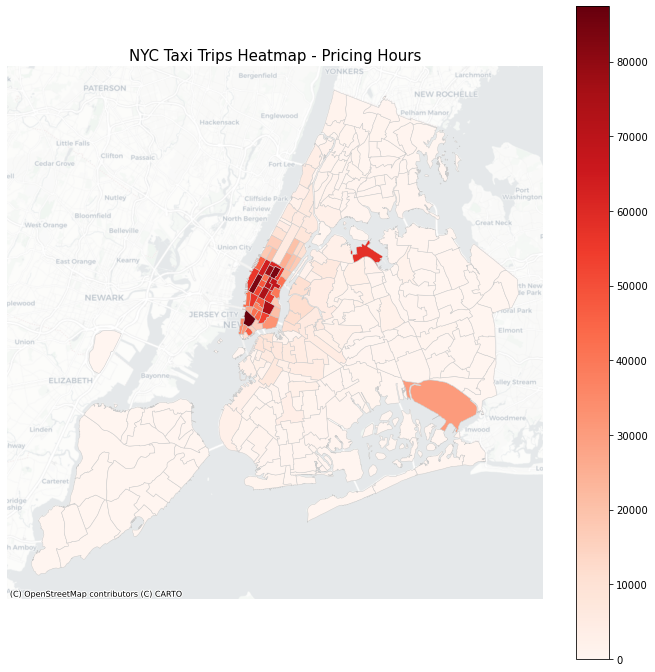

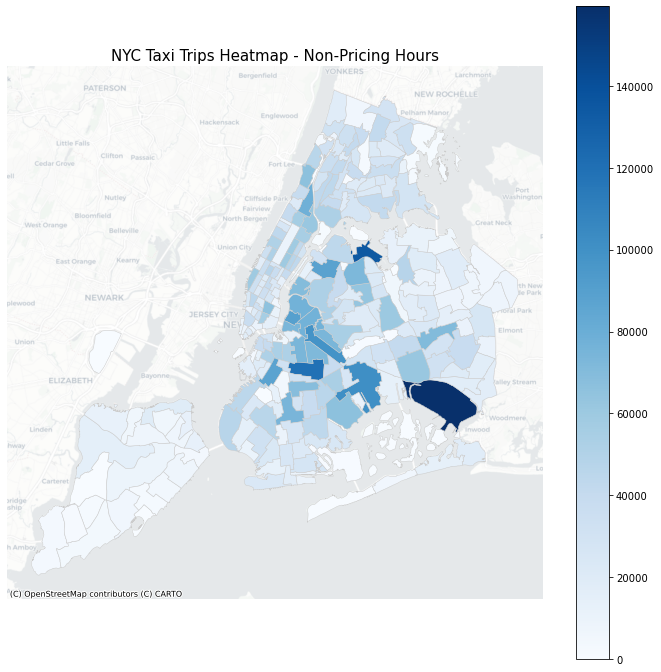

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx



# ✅ Step 2: Convert CRS to Web Mercator for Mapping
if gdf_zones.crs.to_epsg() != 3857:
    gdf_zones = gdf_zones.to_crs(epsg=3857)

# ✅ Step 3: Filter Trips for Pricing and Non-Pricing Hours
df_pricing_hours = df_test[df_test['crosses_60th_st_flag'] == 1]  # Congestion pricing hours
df_non_pricing_hours = df_test[df_test['crosses_60th_st_flag'] == 0]  # Non-pricing hours

# ✅ Step 4: Aggregate Trip Counts by Pickup Location
pricing_trip_counts = df_pricing_hours.groupby('PULocationID').size().reset_index(name='pricing_trips')
non_pricing_trip_counts = df_non_pricing_hours.groupby('PULocationID').size().reset_index(name='non_pricing_trips')

# ✅ Step 5: Merge Trip Counts with Taxi Zones
gdf_zones_pricing = gdf_zones.merge(pricing_trip_counts, left_on="OBJECTID", right_on="PULocationID", how="left")
gdf_zones_non_pricing = gdf_zones.merge(non_pricing_trip_counts, left_on="OBJECTID", right_on="PULocationID", how="left")

# Fill NaN values with 0 (for zones without trips)
gdf_zones_pricing['pricing_trips'].fillna(0, inplace=True)
gdf_zones_non_pricing['non_pricing_trips'].fillna(0, inplace=True)

# ✅ Step 6: Plot Heatmaps

# --- Plot 1: Trips During Congestion Pricing Hours ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_zones_pricing.plot(column='pricing_trips', cmap='Reds', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.6)
plt.title("NYC Taxi Trips Heatmap - Pricing Hours", fontsize=15)
ax.set_axis_off()
plt.show()

# --- Plot 2: Trips During Non-Pricing Hours ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_zones_non_pricing.plot(column='non_pricing_trips', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.6)
plt.title("NYC Taxi Trips Heatmap - Non-Pricing Hours", fontsize=15)
ax.set_axis_off()
plt.show()


In [28]:
df_test.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

     request_datetime    on_scene_datetime     pickup_datetime  \
0 2023-09-15 00:20:35                  NaN 2023-09-15 00:22:35   
1 2023-09-15 00:17:56  2023-09-15 00:19:30 2023-09-15 00:21:05   
2 2023-09-15 00:39:08  2023-09-15 00:42:10 2023-09-15 00:42:29   
3 2023-09-15 00:52:24  2023-09-15 00:54:58 2023-09-15 00:55:17   
4 2023-09-15 00:48:53  2023-09-15 00:51:54 2023-09-15 00:52:52   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231            35       7.354       1892   
1  2023-09-15 00:33:30           235            78       1.780        745   
2  2023-09-15 00:51:21           169            47       1.300        532   
3  2023-09-15 01:12:05            60           168       4.850       1008   
4  2023-09-15 01:08:00            45           249       2.430        908   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                10.68    0.0  0.29       0.95                  0.00   
2                 9.02    0.0  0.25       0.80                  0.00   
3                16.07    0.0  0.44       1.43                  0.00   
4                18.33    0.0  0.50       1.63                  2.75   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        6.81                    0                  0   
3          0.0   0.0       15.95                    0                  0   
4          0.0   0.0       15.20                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                  0                 0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               1   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          1            231  Manhattan   
1                          0            235      Bronx   
2                          0            169      Bronx   
3                          0             60      Bronx   
4                          1             45  Manhattan   

                             Zone_PU service_zone_PU  LocationID_DU  \
0               TriBeCa/Civic Center     Yellow Zone             35   
1  University Heights/Morris Heights       Boro Zone             78   
2                         Mount Hope       Boro Zone             47   
3                  Crotona Park East       Boro Zone            168   
4                          Chinatown     Yellow Zone            249   

  Borough_DU                 Zone_DU service_zone_DU         pickup_time  \
0   Brooklyn             Brownsville       Boro Zone 2023-09-15 00:22:35   
1      Bronx            East Tremont       Boro Zone 2023-09-15 00:21:05   
2      Bronx      Claremont/Bathgate       Boro Zone 2023-09-15 00:42:29   
3      Bronx  Mott Haven/Port Morris       Boro Zone 2023-09-15 00:55:17   
4  Manhattan            West Village     Yellow Zone 2023-09-15 00:52:52   

         dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0 2023-09-15 00:54:07      31.533333       2.000000             9   
1 2023-09-15 00:33:30      12.416667       3.150000             9   
2 2023-09-15 00:51:21       8.866667       3.350000             9   
3 2

In [29]:
# Count occurrences of each ride-hailing service
tnc_counts = df_test['hvfhs_license_num'].value_counts()

# Calculate percentages
tnc_percentages = (tnc_counts / tnc_counts.sum()) * 100

# Print results
print("Percentage of Trips by Ride-Hailing Service:")
print(tnc_percentages)


Percentage of Trips by Ride-Hailing Service:
hvfhs_license_num
Uber    72.19161
Lyft    27.80839
Name: count, dtype: float64


In [30]:
# List of flag variables
flag_vars = [
    'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
    'wav_request_flag', 'wav_match_flag', 'congestion_surcharge_Flag'
]

# Calculate and print percentages for each flag variable
for flag in flag_vars:
    print(f"Percentage Distribution for {flag}:")
    flag_counts = df_test[flag].value_counts(normalize=True) * 100
    print(flag_counts)
    print("\n")


Percentage Distribution for shared_request_flag:
shared_request_flag
0    96.926911
1     3.073089
Name: proportion, dtype: float64


Percentage Distribution for shared_match_flag:
shared_match_flag
0    99.003095
1     0.996905
Name: proportion, dtype: float64


Percentage Distribution for access_a_ride_flag:
access_a_ride_flag
     72.19161
0    27.80839
Name: proportion, dtype: float64


Percentage Distribution for wav_request_flag:
wav_request_flag
0    99.80053
1     0.19947
Name: proportion, dtype: float64


Percentage Distribution for wav_match_flag:
wav_match_flag
0    90.969714
1     9.030286
Name: proportion, dtype: float64


Percentage Distribution for congestion_surcharge_Flag:
congestion_surcharge_Flag
0    59.035537
1    40.964463
Name: proportion, dtype: float64




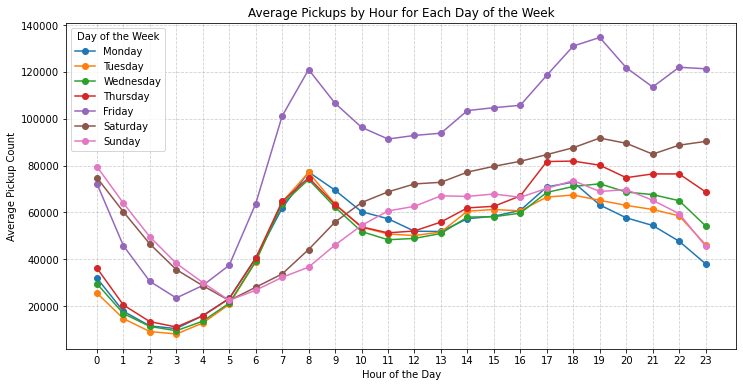

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate the average number of pickups by day and hour
pickup_avg = df_test.groupby(['pickup_day', 'pickup_hour']).size().reset_index(name='avg_pickup_count')

# Reorder days of the week for correct plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pickup_avg['pickup_day'] = pd.Categorical(pickup_avg['pickup_day'], categories=day_order, ordered=True)

# Convert pickup_hour to integer if needed (sometimes it might be stored as a category or float)
pickup_avg['pickup_hour'] = pickup_avg['pickup_hour'].astype(int)

# Ensure `pickup_hour` is sorted within each `pickup_day`
pickup_avg = pickup_avg.sort_values(['pickup_day', 'pickup_hour'])

# Plot line graph for each day
plt.figure(figsize=(12, 6))

for day in day_order:
    subset = pickup_avg[pickup_avg['pickup_day'] == day]
    plt.plot(subset['pickup_hour'].values, subset['avg_pickup_count'].values, marker='o', label=day)

# Formatting the plot
plt.title("Average Pickups by Hour for Each Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Pickup Count")
plt.xticks(range(0, 24))  # Ensure x-axis shows all hours
plt.legend(title="Day of the Week")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [32]:
df_test.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

     request_datetime    on_scene_datetime     pickup_datetime  \
0 2023-09-15 00:20:35                  NaN 2023-09-15 00:22:35   
1 2023-09-15 00:17:56  2023-09-15 00:19:30 2023-09-15 00:21:05   
2 2023-09-15 00:39:08  2023-09-15 00:42:10 2023-09-15 00:42:29   
3 2023-09-15 00:52:24  2023-09-15 00:54:58 2023-09-15 00:55:17   
4 2023-09-15 00:48:53  2023-09-15 00:51:54 2023-09-15 00:52:52   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231            35       7.354       1892   
1  2023-09-15 00:33:30           235            78       1.780        745   
2  2023-09-15 00:51:21           169            47       1.300        532   
3  2023-09-15 01:12:05            60           168       4.850       1008   
4  2023-09-15 01:08:00            45           249       2.430        908   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                10.68    0.0  0.29       0.95                  0.00   
2                 9.02    0.0  0.25       0.80                  0.00   
3                16.07    0.0  0.44       1.43                  0.00   
4                18.33    0.0  0.50       1.63                  2.75   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        6.81                    0                  0   
3          0.0   0.0       15.95                    0                  0   
4          0.0   0.0       15.20                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                  0                 0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               1   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          1            231  Manhattan   
1                          0            235      Bronx   
2                          0            169      Bronx   
3                          0             60      Bronx   
4                          1             45  Manhattan   

                             Zone_PU service_zone_PU  LocationID_DU  \
0               TriBeCa/Civic Center     Yellow Zone             35   
1  University Heights/Morris Heights       Boro Zone             78   
2                         Mount Hope       Boro Zone             47   
3                  Crotona Park East       Boro Zone            168   
4                          Chinatown     Yellow Zone            249   

  Borough_DU                 Zone_DU service_zone_DU         pickup_time  \
0   Brooklyn             Brownsville       Boro Zone 2023-09-15 00:22:35   
1      Bronx            East Tremont       Boro Zone 2023-09-15 00:21:05   
2      Bronx      Claremont/Bathgate       Boro Zone 2023-09-15 00:42:29   
3      Bronx  Mott Haven/Port Morris       Boro Zone 2023-09-15 00:55:17   
4  Manhattan            West Village     Yellow Zone 2023-09-15 00:52:52   

         dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0 2023-09-15 00:54:07      31.533333       2.000000             9   
1 2023-09-15 00:33:30      12.416667       3.150000             9   
2 2023-09-15 00:51:21       8.866667       3.350000             9   
3 2

In [33]:
df_test.shape

(9875667, 80)

In [34]:


# Select relevant columns for summary
columns_of_interest = [
    'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
    'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay', 'shared_request_flag',
    'shared_match_flag', 'wav_request_flag', 'wav_match_flag', 'congestion_surcharge_Flag'
]

# Function to remove outliers using the IQR method
def remove_outliers(df, columns):
    df_filtered = df.copy()
    for col in columns:
        if df_filtered[col].dtype in ['float64', 'int64']:  # Ensure numeric columns
            Q1 = df_filtered[col].quantile(0.25)
            Q3 = df_filtered[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

# Remove outliers
df_filtered = remove_outliers(df_test, columns_of_interest)

# Compute summary statistics
summary_table = df_filtered[columns_of_interest].describe().T
summary_table['Median (50%)'] = df_filtered[columns_of_interest].median()

# Reorder columns for better readability
summary_table = summary_table[['mean', 'std', 'min', 'Median (50%)', 'max']]
summary_table.columns = ['Mean', 'Std.Dev', 'Min', 'Median (50%)', 'Max']

# Display the summary table
from IPython.display import display
display(summary_table)


Mean     Std.Dev   Min  Median (50%)  \
trip_miles                   2.870981    2.140536  0.00          2.20   
trip_time                  902.865796  489.404648  0.00        807.00   
base_passenger_fare         17.365971    7.959461 -4.17         15.45   
tolls                        0.000000    0.000000  0.00          0.00   
bcf                          0.475460    0.218927  0.00          0.42   
sales_tax                    1.533808    0.707076  0.00          1.37   
congestion_surcharge         0.903211    1.291527  0.00          0.00   
airport_fee                  0.000000    0.000000  0.00          0.00   
tips                         0.000000    0.000000  0.00          0.00   
driver_pay                  13.765505    7.059453  0.00         12.22   
shared_request_flag          0.000000    0.000000  0.00          0.00   
shared_match_flag            0.000000    0.000000  0.00          0.00   
wav_request_flag             0.000000    0.000000  0.00          0.00   
wav_match_flag               0.000000    0.000000  0.00          0.00   
congestion_surcharge_Flag    0.328440    0.469646  0.00          0.00   

                                Max  
trip_miles                   13.333  
trip_time                  2726.000  
base_passenger_fare          49.140  
tolls                         0.000  
bcf                           1.180  
sales_tax                     3.680  
congestion_surcharge          5.500  
airport_fee                   0.000  
tips                          0.000  
driver_pay                   34.790  
shared_request_flag           0.000  
shared_match_flag             0.000  
wav_request_flag              0.000  
wav_match_flag                0.000  
congestion_surcharge_Flag     1.000

Aggregated Data:
   pickup_hour hvfhs_license_num  served_trips  avg_wait_time
0            0              Lyft        106821       5.672958
1            0              Uber        242927       5.338772
2            1              Lyft         76976       4.996068
3            1              Uber        162654       4.939634
4            2              Lyft         57002       4.896557


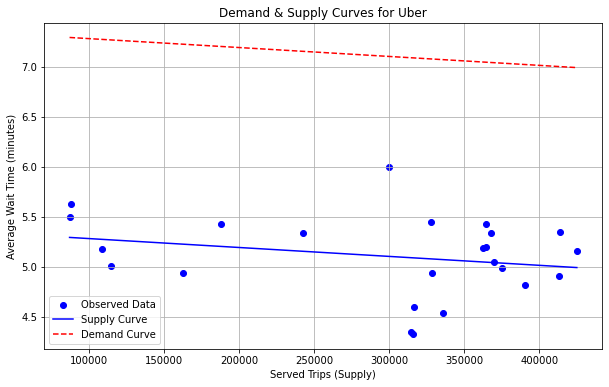

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Data Preparation
# -------------------------

# Ensure df_test is defined.
# For example, you can uncomment and use this dummy DataFrame for testing:
# df_test = pd.DataFrame({
#     'tnc_wait_time': [5.6, 5.3, 4.9, 4.9, 4.8, 6.0, 7.2, 3.8, 5.5, 4.7, -1.0, -0.5],
#     'hvfhs_license_num': ['Lyft', 'Uber', 'Lyft', 'Uber', 'Lyft', 'Uber', 'Lyft', 'Uber', 'Uber', 'Lyft', 'Uber', 'Lyft'],
#     'pickup_hour': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
# })

# Remove rows with negative wait times
df_test = df_test[df_test['tnc_wait_time'] >= 0]

# Aggregate data by pickup_hour and service provider
agg_df = df_test.groupby(['pickup_hour', 'hvfhs_license_num']).agg(
    served_trips=('tnc_wait_time', 'count'),
    avg_wait_time=('tnc_wait_time', 'mean')
).reset_index()

print("Aggregated Data:")
print(agg_df.head())

# -------------------------
# Demand & Supply Curves for a Provider (e.g., Uber)
# -------------------------

provider = 'Uber'
provider_df = agg_df[agg_df['hvfhs_license_num'] == provider]

# Check that there is data for the provider
if provider_df.empty:
    raise ValueError(f"No data available for provider: {provider}")

# Scatter plot: Served Trips vs. Average Wait Time
plt.figure(figsize=(10, 6))
plt.scatter(provider_df['served_trips'], provider_df['avg_wait_time'], color='blue', label='Observed Data')

# Fit a linear regression to get the supply curve
coeffs = np.polyfit(provider_df['served_trips'], provider_df['avg_wait_time'], 1)
supply_line = np.poly1d(coeffs)

# Generate x-values over the range of served trips
x_vals = np.linspace(provider_df['served_trips'].min(), provider_df['served_trips'].max(), 100)
supply_y = supply_line(x_vals)

plt.plot(x_vals, supply_y, color='blue', label='Supply Curve')

# Create a Demand Curve by shifting the Supply Curve upward by an offset
offset = 2.0  # Adjust the offset as needed to represent higher demand
demand_y = supply_y + offset
plt.plot(x_vals, demand_y, color='red', linestyle='--', label='Demand Curve')

plt.xlabel('Served Trips (Supply)')
plt.ylabel('Average Wait Time (minutes)')
plt.title(f'Demand & Supply Curves for {provider}')
plt.legend()
plt.grid(True)
plt.show()


The PULocationID with the most trips is: 138


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

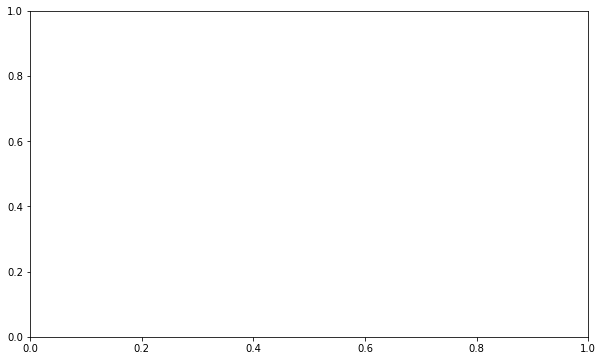

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1. Find PULocationID with the maximum number of trips
# ----------------------------------------------------
# Each row in df_test is presumably a single trip.
# So we can count the number of rows (trips) per PULocationID.
loc_counts = df_test.groupby('PULocationID')['tnc_wait_time'].count().reset_index(name='num_trips')

# Identify the location ID with the maximum number of trips
max_loc_id = loc_counts.loc[loc_counts['num_trips'].idxmax(), 'PULocationID']

print(f"The PULocationID with the most trips is: {max_loc_id}")

# ----------------------------------------------------
# 2. Filter df_test to only include rows from that PULocationID
# ----------------------------------------------------
df_max_loc = df_test[df_test['PULocationID'] == max_loc_id]

# ----------------------------------------------------
# 3. Group by pickup_hour to compute average wait time
# ----------------------------------------------------
agg_df = df_max_loc.groupby('pickup_hour', as_index=False).agg(
    avg_wait_time=('tnc_wait_time', 'mean'),
    num_trips=('tnc_wait_time', 'count')
)

# ----------------------------------------------------
# 4. Plot average wait time by hour of day
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_df, x='pickup_hour', y='avg_wait_time', marker='o')
plt.title(f'Average Wait Time by Hour (PULocationID = {max_loc_id})')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wait Time (minutes)')
plt.grid(True)
plt.show()

# Optional: If you also want to see how many trips at each hour
# you can plot num_trips as well (e.g., a secondary axis).


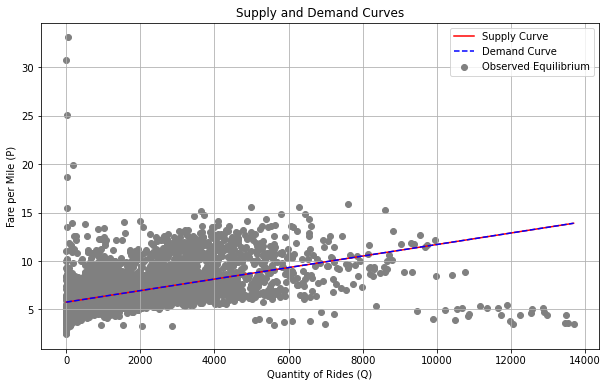

In [40]:
import pandas as pd

# Example: remove any rows with trip_miles <= 0, base_passenger_fare <= 0,
# or extremely large values that are unlikely to be realistic.
# You should adjust these thresholds based on your data distribution.

# 1. Filter out non-positive or unrealistically large trip_miles
df_test = df_test[(df_test['trip_miles'] > 0) & (df_test['trip_miles'] < 500)]  

# 2. Filter out non-positive or unrealistically large base_passenger_fare
df_test = df_test[(df_test['base_passenger_fare'] > 0) & (df_test['base_passenger_fare'] < 1000)]

# 3. Create fare_per_mile
df_test['fare_per_mile'] = df_test['base_passenger_fare'] / df_test['trip_miles']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate fare per mile for each trip
df_test['fare_per_mile'] = df_test['base_passenger_fare'] / df_test['trip_miles']

# 2. Aggregate by time/location
agg_df = df_test.groupby(['pickup_hour', 'PULocationID'], as_index=False).agg({
    'fare_per_mile': 'mean',
    'Serial Number': 'count'  # or something that counts rides
})
agg_df.rename(columns={'Serial Number': 'quantity'}, inplace=True)

# 3. Fit a supply curve
# Suppose you have an array of quantity (Q) and average fare_per_mile (P)
Q = agg_df['quantity'].values
P = agg_df['fare_per_mile'].values

# For demonstration, let's do a simple linear fit for "supply"
supply_coeffs = np.polyfit(Q, P, 1)  # P = a*Q + b
supply_func = np.poly1d(supply_coeffs)

# 4. Fit a demand curve
# If you only have equilibrium points, you might just do another polyfit
# but in reality you'd want a downward slope or more advanced modeling
demand_coeffs = np.polyfit(Q, P, 1)  # or a different approach
demand_func = np.poly1d(demand_coeffs)

# 5. Plot
Q_line = np.linspace(min(Q), max(Q), 100)
plt.figure(figsize=(10, 6))

# Supply curve
plt.plot(Q_line, supply_func(Q_line), 'r-', label='Supply Curve')

# Demand curve
plt.plot(Q_line, demand_func(Q_line), 'b--', label='Demand Curve')

# Scatter actual equilibrium points
plt.scatter(Q, P, color='gray', label='Observed Equilibrium')

plt.xlabel('Quantity of Rides (Q)')
plt.ylabel('Fare per Mile (P)')
plt.title('Supply and Demand Curves')
plt.legend()
plt.grid(True)
plt.show()



In [14]:
# Create separate datasets for Uber and Lyft
df_uber = df_test[df_test['hvfhs_license_num'] == "Uber"].copy()
df_lyft = df_test[df_test['hvfhs_license_num'] == "Lyft"].copy()

# Display the shapes of the new datasets
print(f"Uber Dataset Shape: {df_uber.shape}")
print(f"Lyft Dataset Shape: {df_lyft.shape}")

Uber Dataset Shape: (7129403, 76)
Lyft Dataset Shape: (2746264, 76)


In [15]:
del df_test

In [16]:
# List of columns to drop
columns_to_remove = [
    "lyft_basefare", 
    "lyftXL_basefare", 
    "lyftExComf_basefare", 
    "lyftBlack_basefare", 
    "lyftBlackXL_basefare", 
    "Serial Number"
]

# Drop the specified columns from df_uber
df_uber = df_uber.drop(columns=columns_to_remove, errors='ignore')


In [17]:
# List of columns to drop from df_lyft
columns_to_remove_lyft = [
    "uberx_basefare",
    "uberXL_basefare",
    "uberBlack_basefare",
    "uberSUV_basefare"
]

# Drop the specified columns from df_lyft
df_lyft = df_lyft.drop(columns=columns_to_remove_lyft, errors='ignore')

In [18]:
# Create new columns based on the conditions using vectorized operations
df_uber['UberSUV'] = (df_uber['base_passenger_fare'] >= df_uber['uberSUV_basefare']).astype(int)

df_uber['UberBlack'] = (
    (df_uber['base_passenger_fare'] < df_uber['uberSUV_basefare']) &
    (df_uber['base_passenger_fare'] >= df_uber['uberBlack_basefare'])
).astype(int)

df_uber['UberXL'] = (
    (df_uber['base_passenger_fare'] < df_uber['uberBlack_basefare']) &
    (df_uber['base_passenger_fare'] >= df_uber['uberXL_basefare'])
).astype(int)

df_uber['UberX'] = (df_uber['base_passenger_fare'] < df_uber['uberXL_basefare']).astype(int)



In [19]:
# Create columns for Lyft service types using vectorized operations
df_lyft['lyft'] = (df_lyft['base_passenger_fare'] < df_lyft['lyftXL_basefare']).astype(int)

df_lyft['lyftXL'] = (
    (df_lyft['base_passenger_fare'] >= df_lyft['lyftXL_basefare']) &
    (df_lyft['base_passenger_fare'] < df_lyft['lyftExComf_basefare'])
).astype(int)

df_lyft['lyftExComf'] = (
    (df_lyft['base_passenger_fare'] >= df_lyft['lyftExComf_basefare']) &
    (df_lyft['base_passenger_fare'] < df_lyft['lyftBlack_basefare'])
).astype(int)

df_lyft['lyftBlack'] = (
    (df_lyft['base_passenger_fare'] >= df_lyft['lyftBlack_basefare']) &
    (df_lyft['base_passenger_fare'] < df_lyft['lyftBlackXL_basefare'])
).astype(int)

df_lyft['lyftBlackXL'] = (df_lyft['base_passenger_fare'] >= df_lyft['lyftBlackXL_basefare']).astype(int)


In [20]:
# Extract date from 'request_datetime' for Uber dataset
df_uber['PUrequest_date'] = df_uber['request_datetime'].dt.date

# Extract date from 'request_datetime' for Lyft dataset
df_lyft['PUrequest_date'] = df_lyft['request_datetime'].dt.date


In [21]:
# Add Serial Number column to Uber dataset
df_uber['Serial Number'] = range(1, len(df_uber) + 1)

# Add Serial Number column to Lyft dataset
df_lyft['Serial Number'] = range(1, len(df_lyft) + 1)


In [22]:
# Define the start date for bin calculation
start_date = pd.Timestamp('2022-01-01 00:00:00')  # Adjust this if your data starts at a different date

# For Uber dataset
df_uber['request_datetime'] = pd.to_datetime(df_uber['request_datetime'], errors='coerce')  # Ensure datetime format
df_uber['minutes_since_start'] = (df_uber['request_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index'] = (df_uber['minutes_since_start'] // 10).astype(int) + 1  # 10-minute bins
df_uber['unique_id_PU'] = df_uber['bin_index'].astype(str) + '_' + df_uber['PULocationID'].astype(str)
df_uber['unique_id_DO'] = df_uber['bin_index'].astype(str) + '_' + df_uber['DOLocationID'].astype(str)

# For Lyft dataset
df_lyft['request_datetime'] = pd.to_datetime(df_lyft['request_datetime'], errors='coerce')  # Ensure datetime format
df_lyft['minutes_since_start'] = (df_lyft['request_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index'] = (df_lyft['minutes_since_start'] // 10).astype(int) + 1  # 10-minute bins
df_lyft['unique_id_PU'] = df_lyft['bin_index'].astype(str) + '_' + df_lyft['PULocationID'].astype(str)
df_lyft['unique_id_DO'] = df_lyft['bin_index'].astype(str) + '_' + df_lyft['DOLocationID'].astype(str)


In [23]:
# Count unique bin indices in Uber dataset
unique_bins_uber = df_uber['bin_index'].nunique()
print(f"Total unique bin indices in Uber dataset: {unique_bins_uber}")

# Count unique bin indices in Lyft dataset
unique_bins_lyft = df_lyft['bin_index'].nunique()
print(f"Total unique bin indices in Lyft dataset: {unique_bins_lyft}")
# 16 days × 24 hours/day × 6 bins/hour = 2304 bins

Total unique bin indices in Uber dataset: 2165
Total unique bin indices in Lyft dataset: 2165


In [24]:
# Count unique pickup IDs (unique_id_PU) and dropoff IDs (unique_id_DO) for Uber
unique_pu_uber = df_uber['unique_id_PU'].nunique()
unique_do_uber = df_uber['unique_id_DO'].nunique()

print(f"Total unique pickup IDs (PU) in Uber dataset: {unique_pu_uber}")
print(f"Total unique dropoff IDs (DO) in Uber dataset: {unique_do_uber}")

# Count unique pickup IDs (unique_id_PU) and dropoff IDs (unique_id_DO) for Lyft
unique_pu_lyft = df_lyft['unique_id_PU'].nunique()
unique_do_lyft = df_lyft['unique_id_DO'].nunique()

print(f"Total unique pickup IDs (PU) in Lyft dataset: {unique_pu_lyft}")
print(f"Total unique dropoff IDs (DO) in Lyft dataset: {unique_do_lyft}")


Total unique pickup IDs (PU) in Uber dataset: 496343
Total unique dropoff IDs (DO) in Uber dataset: 500638
Total unique pickup IDs (PU) in Lyft dataset: 449454
Total unique dropoff IDs (DO) in Lyft dataset: 450126


In [25]:
# Calculate Fare_per_Mile and Fare_per_Minute for Uber
df_uber['Fare_per_Mile_uber'] = df_uber.apply(
    lambda x: x['base_passenger_fare'] / x['trip_miles'] if x['trip_miles'] > 0 else 0,
    axis=1
)

df_uber['Fare_per_Minute_uber'] = df_uber.apply(
    lambda x: x['base_passenger_fare'] / x['trip_duration'] if x['trip_duration'] > 0 else 0,
    axis=1
)

# Calculate Fare_per_Mile and Fare_per_Minute for Lyft
df_lyft['Fare_per_Mile_lyft'] = df_lyft.apply(
    lambda x: x['base_passenger_fare'] / x['trip_miles'] if x['trip_miles'] > 0 else 0,
    axis=1
)

df_lyft['Fare_per_Minute_lyft'] = df_lyft.apply(
    lambda x: x['base_passenger_fare'] / x['trip_duration'] if x['trip_duration'] > 0 else 0,
    axis=1
)



In [26]:
# List of columns to calculate percentages for
columns_to_check_uber = ['UberSUV', 'UberBlack', 'UberXL', 'UberX']
columns_to_check_lyft = ['lyft', 'lyftXL', 'lyftExComf', 'lyftBlack', 'lyftBlackXL']

# --- For Uber Dataset ---
# Total number of rows in the Uber dataset
total_rows_uber = df_uber.shape[0]

# Calculate the percentage for each column in Uber
percentages_uber = {}
for col in columns_to_check_uber:
    count = (df_uber[col] == 1).sum()  # Count rows where the column is 1
    percentages_uber[col] = (count / total_rows_uber) * 100  # Calculate percentage

# Convert to a readable DataFrame
percentages_df_uber = pd.DataFrame(list(percentages_uber.items()), columns=['Column', 'Percentage'])

print("Percentage of rows where each Uber column is 1:")
print(percentages_df_uber)

# --- For Lyft Dataset ---
# Total number of rows in the Lyft dataset
total_rows_lyft = df_lyft.shape[0]

# Calculate the percentage for each column in Lyft
percentages_lyft = {}
for col in columns_to_check_lyft:
    count = (df_lyft[col] == 1).sum()  # Count rows where the column is 1
    percentages_lyft[col] = (count / total_rows_lyft) * 100  # Calculate percentage

# Convert to a readable DataFrame
percentages_df_lyft = pd.DataFrame(list(percentages_lyft.items()), columns=['Column', 'Percentage'])

print("\nPercentage of rows where each Lyft column is 1:")
print(percentages_df_lyft)


Percentage of rows where each Uber column is 1:
      Column  Percentage
0    UberSUV    2.624343
1  UberBlack    7.110034
2     UberXL   19.671114
3      UberX   70.594508

Percentage of rows where each Lyft column is 1:
        Column  Percentage
0         lyft   88.406067
1       lyftXL    4.112387
2   lyftExComf    4.202254
3    lyftBlack    6.435070
4  lyftBlackXL    1.354131


In [ ]:
df_uber.head()

In [27]:
# Calculate driver pay per mile for Uber
df_uber['driver_pay_per_mile'] = df_uber['driver_pay'] / df_uber['trip_miles']
df_uber['driver_pay_per_mile'] = df_uber['driver_pay_per_mile'].where(df_uber['trip_miles'] > 0, 0)  # Handle division by zero

# Calculate driver pay per mile for Lyft
df_lyft['driver_pay_per_mile'] = df_lyft['driver_pay'] / df_lyft['trip_miles']
df_lyft['driver_pay_per_mile'] = df_lyft['driver_pay_per_mile'].where(df_lyft['trip_miles'] > 0, 0)  # Handle division by zero

In [28]:
# --- For Uber Dataset ---
# Count rows where trip_miles or trip_duration is zero
zero_count_uber = df_uber[(df_uber['trip_miles'] == 0) | (df_uber['trip_duration'] == 0)].shape[0]

# Total number of trips in Uber dataset
total_trips_uber = df_uber.shape[0]

# Calculate percentage
percent_zero_trips_uber = (zero_count_uber / total_trips_uber) * 100

print(f"Percentage of trips in Uber dataset where 'trip_miles' or 'trip_duration' is zero: {percent_zero_trips_uber:.2f}%")

# --- For Lyft Dataset ---
# Count rows where trip_miles or trip_duration is zero
zero_count_lyft = df_lyft[(df_lyft['trip_miles'] == 0) | (df_lyft['trip_duration'] == 0)].shape[0]

# Total number of trips in Lyft dataset
total_trips_lyft = df_lyft.shape[0]

# Calculate percentage
percent_zero_trips_lyft = (zero_count_lyft / total_trips_lyft) * 100

print(f"Percentage of trips in Lyft dataset where 'trip_miles' or 'trip_duration' is zero: {percent_zero_trips_lyft:.2f}%")



Percentage of trips in Uber dataset where 'trip_miles' or 'trip_duration' is zero: 0.02%
Percentage of trips in Lyft dataset where 'trip_miles' or 'trip_duration' is zero: 0.01%


In [29]:
# --- For Uber Dataset ---
# Remove rows where trip_miles or trip_duration is zero
df_uber = df_uber[(df_uber['trip_miles'] > 0) & (df_uber['trip_duration'] > 0)]

# Display the updated shape of the Uber dataset
print(f"Updated Uber Dataset Shape: {df_uber.shape}")

# --- For Lyft Dataset ---
# Remove rows where trip_miles or trip_duration is zero
df_lyft = df_lyft[(df_lyft['trip_miles'] > 0) & (df_lyft['trip_duration'] > 0)]

# Display the updated shape of the Lyft dataset
print(f"Updated Lyft Dataset Shape: {df_lyft.shape}")



Updated Uber Dataset Shape: (7128012, 84)
Updated Lyft Dataset Shape: (2745870, 86)


In [ ]:
df_uber.head()

In [30]:
# Define the start date for bin calculation
start_date = pd.Timestamp('2022-01-01 00:00:00')  # Adjust this if your data starts at a different date

# --- For Uber Dataset ---
# Ensure datetime formats for request and dropoff times
df_uber['request_datetime'] = pd.to_datetime(df_uber['request_datetime'], errors='coerce')
df_uber['dropoff_datetime'] = pd.to_datetime(df_uber['dropoff_datetime'], errors='coerce')

# Calculate pickup bin index based on request time
df_uber['minutes_since_start_request'] = (df_uber['request_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index_request'] = (df_uber['minutes_since_start_request'] // 10).astype(int) + 1  # 10-minute bins

# Calculate dropoff bin index based on dropoff time
df_uber['minutes_since_start_dropoff'] = (df_uber['dropoff_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index_dropoff'] = (df_uber['minutes_since_start_dropoff'] // 10).astype(int) + 1  # 10-minute bins

# Create unique IDs for pickups and dropoffs
df_uber['unique_id_PU'] = df_uber['bin_index_request'].astype(str) + '_' + df_uber['PULocationID'].astype(str)
df_uber['unique_id_DO'] = df_uber['bin_index_dropoff'].astype(str) + '_' + df_uber['DOLocationID'].astype(str)

# --- For Lyft Dataset ---
# Ensure datetime formats for request and dropoff times
df_lyft['request_datetime'] = pd.to_datetime(df_lyft['request_datetime'], errors='coerce')
df_lyft['dropoff_datetime'] = pd.to_datetime(df_lyft['dropoff_datetime'], errors='coerce')

# Calculate pickup bin index based on request time
df_lyft['minutes_since_start_request'] = (df_lyft['request_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index_request'] = (df_lyft['minutes_since_start_request'] // 10).astype(int) + 1  # 10-minute bins

# Calculate dropoff bin index based on dropoff time
df_lyft['minutes_since_start_dropoff'] = (df_lyft['dropoff_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index_dropoff'] = (df_lyft['minutes_since_start_dropoff'] // 10).astype(int) + 1  # 10-minute bins

# Create unique IDs for pickups and dropoffs
df_lyft['unique_id_PU'] = df_lyft['bin_index_request'].astype(str) + '_' + df_lyft['PULocationID'].astype(str)
df_lyft['unique_id_DO'] = df_lyft['bin_index_dropoff'].astype(str) + '_' + df_lyft['DOLocationID'].astype(str)


In [31]:
# --- Add Pickup Bin Index and Unique ID for Uber Dataset ---
if 'pickup_datetime' in df_uber.columns:
    # Calculate pickup bin index based on pickup time
    df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'], errors='coerce')
    df_uber['minutes_since_start_pickup'] = (df_uber['pickup_datetime'] - start_date).dt.total_seconds() / 60
    df_uber['bin_index_pickup'] = (df_uber['minutes_since_start_pickup'] // 10).astype(int) + 1  # 10-minute bins
    
    # Create unique ID for pickups using pickup_datetime
    df_uber['unique_id_pickup'] = df_uber['bin_index_pickup'].astype(str) + '_' + df_uber['PULocationID'].astype(str)

# --- Add Pickup Bin Index and Unique ID for Lyft Dataset ---
if 'pickup_datetime' in df_lyft.columns:
    # Calculate pickup bin index based on pickup time
    df_lyft['pickup_datetime'] = pd.to_datetime(df_lyft['pickup_datetime'], errors='coerce')
    df_lyft['minutes_since_start_pickup'] = (df_lyft['pickup_datetime'] - start_date).dt.total_seconds() / 60
    df_lyft['bin_index_pickup'] = (df_lyft['minutes_since_start_pickup'] // 10).astype(int) + 1  # 10-minute bins
    
    # Create unique ID for pickups using pickup_datetime
    df_lyft['unique_id_pickup'] = df_lyft['bin_index_pickup'].astype(str) + '_' + df_lyft['PULocationID'].astype(str)


In [ ]:
df_uber.head()

In [32]:
# Define the start date for bin calculation
start_date = pd.Timestamp('2022-01-01 00:00:00')  # Adjust if your data starts at a different date

# --- For Uber Dataset ---
# Ensure datetime formats for request, pickup, and dropoff times
df_uber['request_datetime'] = pd.to_datetime(df_uber['request_datetime'], errors='coerce')
df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'], errors='coerce')
df_uber['dropoff_datetime'] = pd.to_datetime(df_uber['dropoff_datetime'], errors='coerce')

# Calculate bin index based on request time
df_uber['minutes_since_start_request'] = (df_uber['request_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index_request'] = (df_uber['minutes_since_start_request'] // 10).astype(int) + 1  # 10-minute bins
df_uber['unique_id_request'] = df_uber['bin_index_request'].astype(str) + '_' + df_uber['PULocationID'].astype(str)

# Calculate pickup bin index based on pickup time
df_uber['minutes_since_start_pickup'] = (df_uber['pickup_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index_pickup'] = (df_uber['minutes_since_start_pickup'] // 10).astype(int) + 1  # 10-minute bins
df_uber['unique_id_pickup'] = df_uber['bin_index_pickup'].astype(str) + '_' + df_uber['PULocationID'].astype(str)

# Calculate dropoff bin index based on dropoff time
df_uber['minutes_since_start_dropoff'] = (df_uber['dropoff_datetime'] - start_date).dt.total_seconds() / 60
df_uber['bin_index_dropoff'] = (df_uber['minutes_since_start_dropoff'] // 10).astype(int) + 1  # 10-minute bins
df_uber['unique_id_dropoff'] = df_uber['bin_index_dropoff'].astype(str) + '_' + df_uber['DOLocationID'].astype(str)

# --- For Lyft Dataset ---
# Ensure datetime formats for request, pickup, and dropoff times
df_lyft['request_datetime'] = pd.to_datetime(df_lyft['request_datetime'], errors='coerce')
df_lyft['pickup_datetime'] = pd.to_datetime(df_lyft['pickup_datetime'], errors='coerce')
df_lyft['dropoff_datetime'] = pd.to_datetime(df_lyft['dropoff_datetime'], errors='coerce')

# Calculate bin index based on request time
df_lyft['minutes_since_start_request'] = (df_lyft['request_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index_request'] = (df_lyft['minutes_since_start_request'] // 10).astype(int) + 1  # 10-minute bins
df_lyft['unique_id_request'] = df_lyft['bin_index_request'].astype(str) + '_' + df_lyft['PULocationID'].astype(str)

# Calculate pickup bin index based on pickup time
df_lyft['minutes_since_start_pickup'] = (df_lyft['pickup_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index_pickup'] = (df_lyft['minutes_since_start_pickup'] // 10).astype(int) + 1  # 10-minute bins
df_lyft['unique_id_pickup'] = df_lyft['bin_index_pickup'].astype(str) + '_' + df_lyft['PULocationID'].astype(str)

# Calculate dropoff bin index based on dropoff time
df_lyft['minutes_since_start_dropoff'] = (df_lyft['dropoff_datetime'] - start_date).dt.total_seconds() / 60
df_lyft['bin_index_dropoff'] = (df_lyft['minutes_since_start_dropoff'] // 10).astype(int) + 1  # 10-minute bins
df_lyft['unique_id_dropoff'] = df_lyft['bin_index_dropoff'].astype(str) + '_' + df_lyft['DOLocationID'].astype(str)


In [ ]:
df_uber.head()

In [41]:
# For Uber dataset (repeat similarly for Lyft):
def calculate_counts(df):
    # For unique_id_request: count requests, pickups, and dropoffs
    request_request = df.groupby('unique_id_request')['unique_id_request'].count().rename('requested_at_request_id')
    request_pickup = df.groupby('unique_id_request')['unique_id_pickup'].count().rename('pickups_at_request_id')
    request_dropoff = df.groupby('unique_id_request')['unique_id_dropoff'].count().rename('dropoffs_at_request_id')
    
    # For unique_id_pickup: count requests, pickups, and dropoffs
    pickup_request = df.groupby('unique_id_pickup')['unique_id_request'].count().rename('requests_at_pickup_id')
    pickup_pickup = df.groupby('unique_id_pickup')['unique_id_pickup'].count().rename('pickups_at_pickup_id')
    pickup_dropoff = df.groupby('unique_id_pickup')['unique_id_dropoff'].count().rename('dropoffs_at_pickup_id')
    
    # For unique_id_dropoff: count requests, pickups, and dropoffs
    dropoff_request = df.groupby('unique_id_dropoff')['unique_id_request'].count().rename('requests_at_dropoff_id')
    dropoff_pickup = df.groupby('unique_id_dropoff')['unique_id_pickup'].count().rename('pickups_at_dropoff_id')
    dropoff_dropoff = df.groupby('unique_id_dropoff')['unique_id_dropoff'].count().rename('dropoffs_at_dropoff_id')
    
    # Merge all counts back into the original dataframe
    df = df.merge(request_request, on='unique_id_request', how='left')
    df = df.merge(request_pickup, on='unique_id_request', how='left')
    df = df.merge(request_dropoff, on='unique_id_request', how='left')
    df = df.merge(pickup_request, on='unique_id_pickup', how='left')
    df = df.merge(pickup_pickup, on='unique_id_pickup', how='left')
    df = df.merge(pickup_dropoff, on='unique_id_pickup', how='left')
    df = df.merge(dropoff_request, on='unique_id_dropoff', how='left')
    df = df.merge(dropoff_pickup, on='unique_id_dropoff', how='left')
    df = df.merge(dropoff_dropoff, on='unique_id_dropoff', how='left')
    
    return df

# Apply to Uber and Lyft datasets
df_uber = calculate_counts(df_uber)
df_lyft = calculate_counts(df_lyft)

In [ ]:
df_uber.head()  

In [ ]:
# --- Drop Existing Columns if Present ---
columns_to_drop = [
    'requests_count_at_pickup', 'requests_count_at_dropoff',
    'pickups_count_at_pickup', 'pickups_count_at_dropoff',
    'dropoffs_count_at_pickup', 'dropoffs_count_at_dropoff'
]

df_uber = df_uber.drop(columns=[col for col in columns_to_drop if col in df_uber.columns], errors='ignore')

# --- Groupby Operations to Calculate Counts ---

# Count requests per (bin_index_request + PULocationID)
requests_count_at_pickup = df_uber.groupby(['bin_index_request', 'PULocationID']).size().reset_index(name='requests_count_at_pickup')

# Count requests per (bin_index_request + DOLocationID)
requests_count_at_dropoff = df_uber.groupby(['bin_index_request', 'DOLocationID']).size().reset_index(name='requests_count_at_dropoff')

# Count pickups per (bin_index_pickup + PULocationID)
pickups_count_at_pickup = df_uber.groupby(['bin_index_pickup', 'PULocationID']).size().reset_index(name='pickups_count_at_pickup')

# Count pickups per (bin_index_pickup + DOLocationID)
pickups_count_at_dropoff = df_uber.groupby(['bin_index_pickup', 'DOLocationID']).size().reset_index(name='pickups_count_at_dropoff')

# Count dropoffs per (bin_index_dropoff + PULocationID)
dropoffs_count_at_pickup = df_uber.groupby(['bin_index_dropoff', 'PULocationID']).size().reset_index(name='dropoffs_count_at_pickup')

# Count dropoffs per (bin_index_dropoff + DOLocationID)
dropoffs_count_at_dropoff = df_uber.groupby(['bin_index_dropoff', 'DOLocationID']).size().reset_index(name='dropoffs_count_at_dropoff')

# --- Merge Counts Back into df_uber ---

# Merge request counts at pickup
df_uber = df_uber.merge(requests_count_at_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge request counts at dropoff
df_uber = df_uber.merge(requests_count_at_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge pickup counts at pickup
df_uber = df_uber.merge(pickups_count_at_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')

# Merge pickup counts at dropoff
df_uber = df_uber.merge(pickups_count_at_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge dropoff counts at pickup
df_uber = df_uber.merge(dropoffs_count_at_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')

# Merge dropoff counts at dropoff
df_uber = df_uber.merge(dropoffs_count_at_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values ---
# Specify all count columns
count_columns = [
    'requests_count_at_pickup', 'requests_count_at_dropoff',
    'pickups_count_at_pickup', 'pickups_count_at_dropoff',
    'dropoffs_count_at_pickup', 'dropoffs_count_at_dropoff'
]

# Fill missing values with 0 and cast as integers
df_uber[count_columns] = df_uber[count_columns].fillna(0).astype(int)




In [ ]:
df_uber.head()  

In [ ]:
# --- Drop Conflicting or Redundant Columns for Lyft ---
columns_to_drop = [
    'requests_count', 'pickups_count', 'dropoffs_count_at_pickup_x', 'dropoffs_count_at_dropoff_x',
    'requests_count_at_pickup_x', 'requests_count_at_dropoff_x', 'pickups_count_at_pickup_x',
    'pickups_count_at_dropoff_x', 'dropoffs_count_at_pickup_y', 'dropoffs_count_at_dropoff_y',
    'requests_count_at_pickup_y', 'requests_count_at_dropoff_y', 'pickups_count_at_pickup_y'
]

df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

# --- Groupby Operations to Calculate Counts for Lyft ---

# Count requests per (bin_index_request + PULocationID)
requests_count_at_pickup = df_lyft.groupby(['bin_index_request', 'PULocationID']).size().reset_index(name='requests_count_at_pickup')

# Count requests per (bin_index_request + DOLocationID)
requests_count_at_dropoff = df_lyft.groupby(['bin_index_request', 'DOLocationID']).size().reset_index(name='requests_count_at_dropoff')

# Count pickups per (bin_index_pickup + PULocationID)
pickups_count_at_pickup = df_lyft.groupby(['bin_index_pickup', 'PULocationID']).size().reset_index(name='pickups_count_at_pickup')

# Count pickups per (bin_index_pickup + DOLocationID)
pickups_count_at_dropoff = df_lyft.groupby(['bin_index_pickup', 'DOLocationID']).size().reset_index(name='pickups_count_at_dropoff')

# Count dropoffs per (bin_index_dropoff + PULocationID)
dropoffs_count_at_pickup = df_lyft.groupby(['bin_index_dropoff', 'PULocationID']).size().reset_index(name='dropoffs_count_at_pickup')

# Count dropoffs per (bin_index_dropoff + DOLocationID)
dropoffs_count_at_dropoff = df_lyft.groupby(['bin_index_dropoff', 'DOLocationID']).size().reset_index(name='dropoffs_count_at_dropoff')

# --- Merge Counts Back into df_lyft ---

# Merge request counts at pickup
df_lyft = df_lyft.merge(requests_count_at_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge request counts at dropoff
df_lyft = df_lyft.merge(requests_count_at_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge pickup counts at pickup
df_lyft = df_lyft.merge(pickups_count_at_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')

# Merge pickup counts at dropoff
df_lyft = df_lyft.merge(pickups_count_at_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge dropoff counts at pickup
df_lyft = df_lyft.merge(dropoffs_count_at_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')

# Merge dropoff counts at dropoff
df_lyft = df_lyft.merge(dropoffs_count_at_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values ---
# Specify all count columns
count_columns = [
    'requests_count_at_pickup', 'requests_count_at_dropoff',
    'pickups_count_at_pickup', 'pickups_count_at_dropoff',
    'dropoffs_count_at_pickup', 'dropoffs_count_at_dropoff'
]

# Fill missing values with 0 and cast as integers
df_lyft[count_columns] = df_lyft[count_columns].fillna(0).astype(int)

# --- Display a Few Rows for Validation ---
df_lyft.head()


In [ ]:
# List of columns to delete
columns_to_drop = [
    'requested_at_request_id', 'pickups_at_request_id', 'dropoffs_at_request_id',
    'requests_at_pickup_id', 'pickups_at_pickup_id', 'dropoffs_at_pickup_id',
    'requests_at_dropoff_id', 'pickups_at_dropoff_id', 'dropoffs_at_dropoff_id'
]

# Drop columns if they exist
df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

df_lyft.head()


In [61]:


# --- Groupby Operations for Airport Trips ---
# Count airport trips (airport_fee > 0) per (bin_index_request + PULocationID)
airport_trips_count_pickup = (
    df_uber[df_uber['airport_fee'] > 0]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='airport_trips_count_pickup')
)

# Count airport trips (airport_fee > 0) per (bin_index_request + DOLocationID)
airport_trips_count_dropoff = (
    df_uber[df_uber['airport_fee'] > 0]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='airport_trips_count_dropoff')
)

# --- Merge Airport Trip Counts Back into the Dataset ---
# Merge airport trips at pickup
df_uber = df_uber.merge(airport_trips_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge airport trips at dropoff
df_uber = df_uber.merge(airport_trips_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# --- Handle Missing Values ---
# Fill missing values with 0 and cast as integers
airport_columns = ['airport_trips_count_pickup', 'airport_trips_count_dropoff']
df_uber[airport_columns] = df_uber[airport_columns].fillna(0).astype(int)

# --- Repeat the Same Logic for Lyft Dataset ---
df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

# Count airport trips (airport_fee > 0) for Lyft
airport_trips_count_pickup = (
    df_lyft[df_lyft['airport_fee'] > 0]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='airport_trips_count_pickup')
)

airport_trips_count_dropoff = (
    df_lyft[df_lyft['airport_fee'] > 0]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='airport_trips_count_dropoff')
)

# Merge for Lyft
df_lyft = df_lyft.merge(airport_trips_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(airport_trips_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Fill missing values
df_lyft[airport_columns] = df_lyft[airport_columns].fillna(0).astype(int)




In [ ]:
# --- Drop Conflicting or Redundant Columns ---
columns_to_drop = [
    'shared_request_flag_count_pickup', 'shared_request_flag_count_dropoff',
    'shared_match_flag_count_pickup', 'shared_match_flag_count_dropoff'
]

df_uber = df_uber.drop(columns=[col for col in columns_to_drop if col in df_uber.columns], errors='ignore')

# --- Groupby Operations for Shared Flags ---
# Count shared requests per (bin_index_request + PULocationID) where shared_request_flag = 1
shared_request_count_pickup = (
    df_uber[df_uber['shared_request_flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='shared_request_flag_count_pickup')
)

# Count shared requests per (bin_index_request + DOLocationID) where shared_request_flag = 1
shared_request_count_dropoff = (
    df_uber[df_uber['shared_request_flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='shared_request_flag_count_dropoff')
)

# Count shared matches per (bin_index_request + PULocationID) where shared_match_flag = 1
shared_match_count_pickup = (
    df_uber[df_uber['shared_match_flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='shared_match_flag_count_pickup')
)

# Count shared matches per (bin_index_request + DOLocationID) where shared_match_flag = 1
shared_match_count_dropoff = (
    df_uber[df_uber['shared_match_flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='shared_match_flag_count_dropoff')
)

# --- Merge Counts Back into df_uber ---
# Merge shared request counts at pickup
df_uber = df_uber.merge(shared_request_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge shared request counts at dropoff
df_uber = df_uber.merge(shared_request_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge shared match counts at pickup
df_uber = df_uber.merge(shared_match_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge shared match counts at dropoff
df_uber = df_uber.merge(shared_match_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# --- Handle Missing Values ---
# Specify all count columns
shared_flag_columns = [
    'shared_request_flag_count_pickup', 'shared_request_flag_count_dropoff',
    'shared_match_flag_count_pickup', 'shared_match_flag_count_dropoff'
]

# Fill missing values with 0 and cast as integers
df_uber[shared_flag_columns] = df_uber[shared_flag_columns].fillna(0).astype(int)

# --- Repeat the Same Logic for Lyft Dataset ---
df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

# Group and calculate shared request and match counts for Lyft
shared_request_count_pickup = (
    df_lyft[df_lyft['shared_request_flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='shared_request_flag_count_pickup')
)

shared_request_count_dropoff = (
    df_lyft[df_lyft['shared_request_flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='shared_request_flag_count_dropoff')
)

shared_match_count_pickup = (
    df_lyft[df_lyft['shared_match_flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='shared_match_flag_count_pickup')
)

shared_match_count_dropoff = (
    df_lyft[df_lyft['shared_match_flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID'])
    .size()
    .reset_index(name='shared_match_flag_count_dropoff')
)

# Merge for Lyft
df_lyft = df_lyft.merge(shared_request_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(shared_request_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')
df_lyft = df_lyft.merge(shared_match_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(shared_match_count_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Fill missing values
df_lyft[shared_flag_columns] = df_lyft[shared_flag_columns].fillna(0).astype(int)

# --- Display a Few Rows for Validation ---
print("Uber Dataset with Shared Flag Counts:")
print(df_uber[['bin_index_request', 'PULocationID', 'shared_request_flag_count_pickup', 'shared_match_flag_count_pickup']].head())

print("\nLyft Dataset with Shared Flag Counts:")
print(df_lyft[['bin_index_request', 'PULocationID', 'shared_request_flag_count_pickup', 'shared_match_flag_count_pickup']].head())


In [ ]:
df_uber.head()


In [ ]:


# --- Groupby Operations to Calculate Counts ---

# Count requests per (bin_index_request + PULocationID)
avg_fare_at_requests_count_at_pickup = df_uber.groupby(['bin_index_request', 'PULocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_requests_count_at_pickup')

# Count requests per (bin_index_request + DOLocationID)
avg_fare_at_requests_count_at_dropoff = df_uber.groupby(['bin_index_request', 'DOLocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_requests_count_at_dropoff')

# Count pickups per (bin_index_pickup + PULocationID)
avg_fare_at_pickups_count_at_pickup = df_uber.groupby(['bin_index_pickup', 'PULocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_pickups_count_at_pickup')

# Count pickups per (bin_index_pickup + DOLocationID)
avg_fare_at_pickups_count_at_dropoff = df_uber.groupby(['bin_index_pickup', 'DOLocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_pickups_count_at_dropoff')

# Count dropoffs per (bin_index_dropoff + PULocationID)
avg_fare_at_dropoffs_count_at_pickup = df_uber.groupby(['bin_index_dropoff', 'PULocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_dropoffs_count_at_pickup')

# Count dropoffs per (bin_index_dropoff + DOLocationID)
avg_fare_at_dropoffs_count_at_dropoff = df_uber.groupby(['bin_index_dropoff', 'DOLocationID'])['base_passenger_fare'].mean().reset_index(name='avg_fare_at_dropoffs_count_at_dropoff')

# --- Merge Counts Back into df_uber ---

# Merge request counts at pickup
df_uber = df_uber.merge(avg_fare_at_requests_count_at_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# Merge request counts at dropoff
df_uber = df_uber.merge(avg_fare_at_requests_count_at_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge pickup counts at pickup
df_uber = df_uber.merge(avg_fare_at_pickups_count_at_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')

# Merge pickup counts at dropoff
df_uber = df_uber.merge(avg_fare_at_pickups_count_at_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge dropoff counts at pickup
df_uber = df_uber.merge(avg_fare_at_dropoffs_count_at_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')

# Merge dropoff counts at dropoff
df_uber = df_uber.merge(avg_fare_at_dropoffs_count_at_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values ---
# Specify all count columns
count_columns = [
    'avg_fare_at_requests_count_at_pickup', 'avg_fare_at_requests_count_at_dropoff',
    'avg_fare_at_pickups_count_at_pickup', 'avg_fare_at_pickups_count_at_dropoff',
    'avg_fare_at_dropoffs_count_at_pickup', 'avg_fare_at_dropoffs_count_at_dropoff'
]

# Fill missing values with 0 and cast as integers
df_uber[count_columns] = df_uber[count_columns].fillna(0).astype(int)




In [ ]:
# --- Drop Previously Created Variables ---
columns_to_drop = [
    'avg_fare_request_pickup', 'avg_fare_request_dropoff',
    'avg_fare_pickup_pickup', 'avg_fare_pickup_dropoff',
    'avg_fare_dropoff_pickup', 'avg_fare_dropoff_dropoff'
]

df_uber = df_uber.drop(columns=[col for col in columns_to_drop if col in df_uber.columns], errors='ignore')

# --- Groupby Operations to Calculate Average Fare per Mile ---

# Average fare per mile for requests per (bin_index_request + PULocationID)
avg_fare_per_mile_request_pickup = df_uber.groupby(['bin_index_request', 'PULocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_request_pickup')

# Average fare per mile for requests per (bin_index_request + DOLocationID)
avg_fare_per_mile_request_dropoff = df_uber.groupby(['bin_index_request', 'DOLocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_request_dropoff')

# Average fare per mile for pickups per (bin_index_pickup + PULocationID)
avg_fare_per_mile_pickup_pickup = df_uber.groupby(['bin_index_pickup', 'PULocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_pickup_pickup')

# Average fare per mile for pickups per (bin_index_pickup + DOLocationID)
avg_fare_per_mile_pickup_dropoff = df_uber.groupby(['bin_index_pickup', 'DOLocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_pickup_dropoff')

# Average fare per mile for dropoffs per (bin_index_dropoff + PULocationID)
avg_fare_per_mile_dropoff_pickup = df_uber.groupby(['bin_index_dropoff', 'PULocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_dropoff_pickup')

# Average fare per mile for dropoffs per (bin_index_dropoff + DOLocationID)
avg_fare_per_mile_dropoff_dropoff = df_uber.groupby(['bin_index_dropoff', 'DOLocationID'])['Fare_per_Mile_uber'].mean().reset_index(name='avg_fare_per_mile_dropoff_dropoff')

# --- Merge Average Fares Back into df_uber ---

# Merge average fare per mile for requests
df_uber = df_uber.merge(avg_fare_per_mile_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_fare_per_mile_request_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge average fare per mile for pickups
df_uber = df_uber.merge(avg_fare_per_mile_pickup_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_fare_per_mile_pickup_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge average fare per mile for dropoffs
df_uber = df_uber.merge(avg_fare_per_mile_dropoff_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_fare_per_mile_dropoff_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values with Overall Average ---

# Specify all average fare per mile columns
average_columns_fare_per_mile = [
    'avg_fare_per_mile_request_pickup', 'avg_fare_per_mile_request_dropoff',
    'avg_fare_per_mile_pickup_pickup', 'avg_fare_per_mile_pickup_dropoff',
    'avg_fare_per_mile_dropoff_pickup', 'avg_fare_per_mile_dropoff_dropoff'
]

# Fill missing values with the column's overall mean
for col in average_columns_fare_per_mile:
    overall_mean = df_uber[col].mean(skipna=True)  # Calculate overall mean
    df_uber[col] = df_uber[col].fillna(overall_mean)  # Fill NaN with the mean




In [ ]:
# --- Drop Previously Created Variables ---
columns_to_drop = [
    'avg_fare_per_mile_request_pickup', 'avg_fare_per_mile_request_dropoff',
    'avg_fare_per_mile_pickup_pickup', 'avg_fare_per_mile_pickup_dropoff',
    'avg_fare_per_mile_dropoff_pickup', 'avg_fare_per_mile_dropoff_dropoff'
]

df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

# --- Groupby Operations to Calculate Average Fare per Mile ---

# Average fare per mile for requests per (bin_index_request + PULocationID)
avg_fare_per_mile_request_pickup = df_lyft.groupby(['bin_index_request', 'PULocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_request_pickup')

# Average fare per mile for requests per (bin_index_request + DOLocationID)
avg_fare_per_mile_request_dropoff = df_lyft.groupby(['bin_index_request', 'DOLocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_request_dropoff')

# Average fare per mile for pickups per (bin_index_pickup + PULocationID)
avg_fare_per_mile_pickup_pickup = df_lyft.groupby(['bin_index_pickup', 'PULocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_pickup_pickup')

# Average fare per mile for pickups per (bin_index_pickup + DOLocationID)
avg_fare_per_mile_pickup_dropoff = df_lyft.groupby(['bin_index_pickup', 'DOLocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_pickup_dropoff')

# Average fare per mile for dropoffs per (bin_index_dropoff + PULocationID)
avg_fare_per_mile_dropoff_pickup = df_lyft.groupby(['bin_index_dropoff', 'PULocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_dropoff_pickup')

# Average fare per mile for dropoffs per (bin_index_dropoff + DOLocationID)
avg_fare_per_mile_dropoff_dropoff = df_lyft.groupby(['bin_index_dropoff', 'DOLocationID'])['Fare_per_Mile_lyft'].mean().reset_index(name='avg_fare_per_mile_dropoff_dropoff')

# --- Merge Average Fares Back into df_lyft ---

# Merge average fare per mile for requests
df_lyft = df_lyft.merge(avg_fare_per_mile_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_fare_per_mile_request_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge average fare per mile for pickups
df_lyft = df_lyft.merge(avg_fare_per_mile_pickup_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_fare_per_mile_pickup_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge average fare per mile for dropoffs
df_lyft = df_lyft.merge(avg_fare_per_mile_dropoff_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_fare_per_mile_dropoff_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values with Overall Average ---

# Specify all average fare per mile columns
average_columns_fare_per_mile = [
    'avg_fare_per_mile_request_pickup', 'avg_fare_per_mile_request_dropoff',
    'avg_fare_per_mile_pickup_pickup', 'avg_fare_per_mile_pickup_dropoff',
    'avg_fare_per_mile_dropoff_pickup', 'avg_fare_per_mile_dropoff_dropoff'
]

# Fill missing values with the column's overall mean
for col in average_columns_fare_per_mile:
    overall_mean = df_lyft[col].mean(skipna=True)  # Calculate overall mean
    df_lyft[col] = df_lyft[col].fillna(overall_mean)  # Fill NaN with the mean




In [ ]:
# --- Groupby Operations to Calculate Average TNC Wait Time ---

# Average TNC wait time per (bin_index_request + PULocationID)
avg_wait_time_request_pickup = df_uber.groupby(['bin_index_request', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_request_pickup')

# Average TNC wait time per (bin_index_request + DOLocationID)
avg_wait_time_request_dropoff = df_uber.groupby(['bin_index_request', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_request_dropoff')

# Average TNC wait time per (bin_index_pickup + PULocationID)
avg_wait_time_pickup_pickup = df_uber.groupby(['bin_index_pickup', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_pickup_pickup')

# Average TNC wait time per (bin_index_pickup + DOLocationID)
avg_wait_time_pickup_dropoff = df_uber.groupby(['bin_index_pickup', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_pickup_dropoff')

# Average TNC wait time per (bin_index_dropoff + PULocationID)
avg_wait_time_dropoff_pickup = df_uber.groupby(['bin_index_dropoff', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_dropoff_pickup')

# Average TNC wait time per (bin_index_dropoff + DOLocationID)
avg_wait_time_dropoff_dropoff = df_uber.groupby(['bin_index_dropoff', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_dropoff_dropoff')

# --- Merge Average Wait Times Back into df_uber ---

# Merge average wait times for requests
df_uber = df_uber.merge(avg_wait_time_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_wait_time_request_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge average wait times for pickups
df_uber = df_uber.merge(avg_wait_time_pickup_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_wait_time_pickup_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge average wait times for dropoffs
df_uber = df_uber.merge(avg_wait_time_dropoff_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_wait_time_dropoff_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values with Overall Average ---

# Specify all average TNC wait time columns
average_columns_wait_time = [
    'avg_wait_time_request_pickup', 'avg_wait_time_request_dropoff',
    'avg_wait_time_pickup_pickup', 'avg_wait_time_pickup_dropoff',
    'avg_wait_time_dropoff_pickup', 'avg_wait_time_dropoff_dropoff'
]

# Fill missing values with the column's overall mean
for col in average_columns_wait_time:
    overall_mean = df_uber[col].mean(skipna=True)  # Calculate overall mean
    df_uber[col] = df_uber[col].fillna(overall_mean)  # Fill NaN with the mean

df_uber.head()


In [ ]:
# --- Groupby Operations to Calculate Average TNC Wait Time ---

# Average TNC wait time per (bin_index_request + PULocationID)
avg_wait_time_request_pickup = df_lyft.groupby(['bin_index_request', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_request_pickup')

# Average TNC wait time per (bin_index_request + DOLocationID)
avg_wait_time_request_dropoff = df_lyft.groupby(['bin_index_request', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_request_dropoff')

# Average TNC wait time per (bin_index_pickup + PULocationID)
avg_wait_time_pickup_pickup = df_lyft.groupby(['bin_index_pickup', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_pickup_pickup')

# Average TNC wait time per (bin_index_pickup + DOLocationID)
avg_wait_time_pickup_dropoff = df_lyft.groupby(['bin_index_pickup', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_pickup_dropoff')

# Average TNC wait time per (bin_index_dropoff + PULocationID)
avg_wait_time_dropoff_pickup = df_lyft.groupby(['bin_index_dropoff', 'PULocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_dropoff_pickup')

# Average TNC wait time per (bin_index_dropoff + DOLocationID)
avg_wait_time_dropoff_dropoff = df_lyft.groupby(['bin_index_dropoff', 'DOLocationID'])['tnc_wait_time'].mean().reset_index(name='avg_wait_time_dropoff_dropoff')

# --- Merge Average Wait Times Back into df_lyft ---

# Merge average wait times for requests
df_lyft = df_lyft.merge(avg_wait_time_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_wait_time_request_dropoff, on=['bin_index_request', 'DOLocationID'], how='left')

# Merge average wait times for pickups
df_lyft = df_lyft.merge(avg_wait_time_pickup_pickup, on=['bin_index_pickup', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_wait_time_pickup_dropoff, on=['bin_index_pickup', 'DOLocationID'], how='left')

# Merge average wait times for dropoffs
df_lyft = df_lyft.merge(avg_wait_time_dropoff_pickup, on=['bin_index_dropoff', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_wait_time_dropoff_dropoff, on=['bin_index_dropoff', 'DOLocationID'], how='left')

# --- Handle Missing Values with Overall Average ---

# Specify all average TNC wait time columns
average_columns_wait_time = [
    'avg_wait_time_request_pickup', 'avg_wait_time_request_dropoff',
    'avg_wait_time_pickup_pickup', 'avg_wait_time_pickup_dropoff',
    'avg_wait_time_dropoff_pickup', 'avg_wait_time_dropoff_dropoff'
]

# Fill missing values with the column's overall mean
for col in average_columns_wait_time:
    overall_mean = df_lyft[col].mean(skipna=True)  # Calculate overall mean
    df_lyft[col] = df_lyft[col].fillna(overall_mean)  # Fill NaN with the mean


df_lyft.head()


In [ ]:
df_uber.head()

In [ ]:
print(list(df_uber.columns))


In [ ]:
import pandas as pd

# --------------------------
# Shared Preprocessing
# --------------------------

def preprocess_bins(df):
    """Convert numeric bin indices directly to integers"""
    df['bin_index_pickup'] = df['minutes_since_start_pickup'].astype(int)
    df['bin_index_dropoff'] = df['minutes_since_start_dropoff'].astype(int)
    return df

# --------------------------
# Rename Columns with Suffixes
# --------------------------

def rename_suffix_columns(df):
    """
    Rename columns with any suffix (_x, _y, _merge) to avoid conflicts.
    """
    df.columns = [col.split('_')[0] if '_' in col else col for col in df.columns]
    return df

# --------------------------
# Dynamic Adjustment Logic
# --------------------------

def calculate_adjusted_drivers(df, platform):
    """
    Improved driver availability adjustment using multiple wait time metrics
    """
    # 1. Calculate baseline driver count
    trips_ending = df.groupby(['DOLocationID_x', 'bin_index_dropoff']).size().reset_index(name='baseline_drivers')
    print("Trips Ending DataFrame:\n", trips_ending.head())  # Debugging step
    
    # 2. Expand to eligible time bins manually
    trips_ending_expanded = pd.concat([
        trips_ending.assign(request_bin=trips_ending['bin_index_dropoff']),  # Current bin
        trips_ending.assign(request_bin=trips_ending['bin_index_dropoff'] - 1)  # Previous bin
    ])
    trips_ending_expanded = trips_ending_expanded.drop(columns=['bin_index_dropoff'])
    print("Expanded Trips Ending DataFrame:\n", trips_ending_expanded.head())  # Debugging step

    # 3. Merge with main dataframe
    df = df.merge(
        trips_ending_expanded,
        left_on=['PULocationID', 'bin_index_pickup'],
        right_on=['DOLocationID_x', 'request_bin'],
        how='left',
        suffixes=('', '_merge')
    )
    print("DataFrame After Merge:\n", df[['PULocationID', 'bin_index_pickup', 'baseline_drivers']].head())  # Debugging step
    
    # 4. Check if `baseline_drivers` exists after merge
    if 'baseline_drivers' not in df.columns:
        print("Columns in DataFrame after merge:", df.columns)  # Debugging step
        raise ValueError("Baseline drivers column is missing after the merge.")

    # 5. Fill missing baseline drivers with 0
    df['baseline_drivers'] = df['baseline_drivers'].fillna(0)
    
    # 6. Calculate total baseline drivers
    df['total_baseline'] = df.groupby(['PULocationID', 'bin_index_pickup'])['baseline_drivers'].transform('sum')
    
    # 7. Dynamic adjustment using multiple wait time metrics
    # Calculate baseline wait times from historical data
    baseline_request_pickup = df['avg_wait_time_request_pickup'].mean(skipna=True)
    baseline_dropoff_pickup = df['avg_wait_time_dropoff_pickup'].mean(skipna=True)
    
    # Handle NaN in wait times
    df['avg_wait_time_request_pickup'] = df['avg_wait_time_request_pickup'].fillna(baseline_request_pickup)
    df['avg_wait_time_dropoff_pickup'] = df['avg_wait_time_dropoff_pickup'].fillna(baseline_dropoff_pickup)
    
    # Calculate availability scores (inverse relationship with wait times)
    df['availability_score'] = (
        (baseline_request_pickup / df['avg_wait_time_request_pickup']) * 0.6 +  # Passenger wait time impact
        (baseline_dropoff_pickup / df['avg_wait_time_dropoff_pickup']) * 0.4    # Driver relocation impact
    )
    
    # Apply smoothing to handle extreme values
    df['availability_score'] = df['availability_score'].clip(lower=0.5, upper=1.5)
    
    # Adjust driver count
    df['adjusted_drivers'] = df['total_baseline'] * df['availability_score']
    
    # Avoid division by zero in trips per driver
    df['adjusted_drivers'] = df['adjusted_drivers'].replace(0, 1e-6)
    
    # 8. Calculate trips per driver
    df['trips_per_driver'] = 1 / df['adjusted_drivers']
    
    # 9. Filter valid wait times (0-15 minutes)
    df['wait_time'] = (df['pickup_datetime'] - df['request_datetime']).dt.total_seconds() / 60
    df = df[(df['wait_time'] >= 0) & (df['wait_time'] <= 15)]
    
    return df

# --------------------------
# Uber Data Processing
# --------------------------

df_uber = preprocess_bins(df_uber)
df_uber = calculate_adjusted_drivers(df_uber, 'uber')
uber_stats = df_uber['trips_per_driver'].agg(['mean', 'median', 'std', 'min', 'max'])

# --------------------------
# Lyft Data Processing
# --------------------------

df_lyft = preprocess_bins(df_lyft)
df_lyft = calculate_adjusted_drivers(df_lyft, 'lyft')
lyft_stats = df_lyft['trips_per_driver'].agg(['mean', 'median', 'std', 'min', 'max'])

# --------------------------
# Results
# --------------------------

print("Uber Trips per Driver Statistics (Improved Adjustment):")
print(uber_stats)

print("\nLyft Trips per Driver Statistics (Improved Adjustment):")
print(lyft_stats)


In [ ]:
# Check distribution of availability scores
print(df_uber['availability_score'].describe())
print(df_lyft['availability_score'].describe())

# Compare with static method
static_uber = df_uber['total_baseline'] / (1 - 0.35)
print("Correlation between dynamic and static methods:", df_uber['trips_per_driver'].corr(1/static_uber))

In [ ]:
df_uber.head()

In [ ]:
df_uber.head()

In [102]:
# Save to CSV files
df_uber.to_csv('uber_trips.csv', index=False)
df_lyft.to_csv('lyft_trips.csv', index=False)

In [3]:
#df_uber = pd.read_csv('uber_trips.csv')
df_lyft = pd.read_csv('lyft_trips.csv')

In [4]:
df_lyft.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Lyft               B03406                  NaN   
2              Lyft               B03406                  NaN   
3              Lyft               B03406                  NaN   
4              Lyft               B03406                  NaN   

      request_datetime on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:20:35               NaN  2023-09-15 00:22:35   
1  2023-09-15 00:04:21               NaN  2023-09-15 00:11:43   
2  2023-09-15 00:11:44               NaN  2023-09-15 00:13:26   
3  2023-09-15 00:00:06               NaN  2023-09-15 00:08:31   
4  2023-09-15 00:22:18               NaN  2023-09-15 00:29:49   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231              35       7.354       1892   
1  2023-09-15 00:15:28           139             203       0.797        225   
2  2023-09-15 00:45:27            45              61       5.392       1921   
3  2023-09-15 00:14:46            95              95       1.079        375   
4  2023-09-15 00:39:36           205              38       2.296        587   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                 8.10    0.0  0.20       0.64                  0.00   
2                24.72    0.0  0.68       2.19                  2.75   
3                 7.94    0.0  0.22       0.70                  0.00   
4                12.33    0.0  0.34       1.10                  0.00   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        5.47                    0                  0   
2          0.0   0.0       25.36                    0                  0   
3          0.0   0.0        5.47                    0                  0   
4          0.0   0.0        8.61                    0                  0   

   access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                   0                 0               0   
1                   0                 0               0   
2                   0                 0               0   
3                   0                 0               0   
4                   0                 0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU               Zone_PU  \
0                          1            231  Manhattan  TriBeCa/Civic Center   
1                          0            139     Queens             Laurelton   
2                          1             45  Manhattan             Chinatown   
3                          0             95     Queens          Forest Hills   
4                          0            205     Queens          Saint Albans   

  service_zone_PU  LocationID_DU Borough_DU              Zone_DU  \
0     Yellow Zone             35   Brooklyn          Brownsville   
1       Boro Zone            203     Queens             Rosedale   
2     Yellow Zone             61   Brooklyn  Crown Heights North   
3       Boro Zone             95     Queens         Forest Hills   
4       Boro Zone             38     Queens      Cambria Heights   

  service_zone_DU          pickup_time         dropoff_time  trip_duration  \
0       Boro Zone  2023-09-15 00:22:35  2023-09-15 00:54:07      31.533333   
1       Boro Zone  2023-09-15 00:11:43  2023-09-15 00:15:28       3.750000   
2       Boro Zone  2023-09-15 00:13:26  2023-09-15 00:45:27      32.016667   
3       Boro Zone  2023-09-15 00:08:31  2023-09-15 00:14:46       6.250000   
4       Boro Zone  2023-09-15 00:29:49  2023-09-15 00:39:36       9.783333   

   tnc_wait_time  pickup_month  pickup_hour pickup_date pickup_day_name  \
0       2.000000             9            0  2023-09-15          F

In [24]:
df_lyft['Fare_per_Mile_lyft'].mean()

7.0338890679112085

In [4]:
df_uber.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Uber               B03404               B03404   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

      request_datetime    on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
1  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
2  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
3  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
4  2023-09-15 00:39:08  2023-09-15 00:42:10  2023-09-15 00:42:29   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:33:30           235              78        1.78        745   
1  2023-09-15 00:33:30           235              78        1.78        745   
2  2023-09-15 00:33:30           235              78        1.78        745   
3  2023-09-15 00:33:30           235              78        1.78        745   
4  2023-09-15 00:51:21           169              47        1.30        532   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                10.68    0.0  0.29       0.95                   0.0   
1                10.68    0.0  0.29       0.95                   0.0   
2                10.68    0.0  0.29       0.95                   0.0   
3                10.68    0.0  0.29       0.95                   0.0   
4                 9.02    0.0  0.25       0.80                   0.0   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0        9.44                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        9.44                    0                  0   
3          0.0   0.0        9.44                    0                  0   
4          0.0   0.0        6.81                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                                    0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          0            235      Bronx   
1                          0            235      Bronx   
2                          0            235      Bronx   
3                          0            235      Bronx   
4                          0            169      Bronx   

                             Zone_PU service_zone_PU  LocationID_DU  \
0  University Heights/Morris Heights       Boro Zone             78   
1  University Heights/Morris Heights       Boro Zone             78   
2  University Heights/Morris Heights       Boro Zone             78   
3  University Heights/Morris Heights       Boro Zone             78   
4                         Mount Hope       Boro Zone             47   

  Borough_DU             Zone_DU service_zone_DU          pickup_time  \
0      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
1      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
2      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
3      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
4      Bronx  Claremont/Bathgate       Boro Zone  2023-09-15 00:42:29   

          dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0  2023-09-15 00:33:30      12.416667           3.15             9   
1  2023-09-15 00:33:30      12.416667           3.15             9   
2  2023-09-15 00:33:30      12.416667           3.15           

In [6]:
'''

# --- Drop Conflicting or Redundant Columns for Tolled Trips ---
columns_to_drop = [
    'tolled_trip_flag_count_pickup', 'tolled_trip_flag_count_dropoff'
]

df_uber = df_uber.drop(columns=[col for col in columns_to_drop if col in df_uber.columns], errors='ignore')

# --- Groupby Operations for Tolled Trips ---
# Count tolled trips per (bin_index_request + PULocationID) where congestion_surcharge_Flag = 1
tolled_trip_count_pickup = (
    df_uber[df_uber['congestion_surcharge_Flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='tolled_trip_flag_count_pickup')
)

# Count tolled trips per (bin_index_request + DOLocationID) where congestion_surcharge_Flag = 1
tolled_trip_count_dropoff = (
    df_uber[df_uber['congestion_surcharge_Flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID_x'])
    .size()
    .reset_index(name='tolled_trip_flag_count_dropoff')
)

# --- Merge Tolled Trip Counts Back into df_uber ---
df_uber = df_uber.merge(tolled_trip_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(tolled_trip_count_dropoff, on=['bin_index_request', 'DOLocationID_x'], how='left')

# --- Handle Missing Values ---
tolled_trip_columns = ['tolled_trip_flag_count_pickup', 'tolled_trip_flag_count_dropoff']
df_uber[tolled_trip_columns] = df_uber[tolled_trip_columns].fillna(0).astype(int)

''' 

# --- Drop Conflicting or Redundant Columns for Tolled Trips ---
columns_to_drop = [
    'tolled_trip_flag_count_pickup', 'tolled_trip_flag_count_dropoff'
]

# --- Repeat the Same Logic for Lyft Dataset ---
df_lyft = df_lyft.drop(columns=[col for col in columns_to_drop if col in df_lyft.columns], errors='ignore')

# Group and calculate tolled trip counts for Lyft
tolled_trip_count_pickup = (
    df_lyft[df_lyft['congestion_surcharge_Flag'] == 1]
    .groupby(['bin_index_request', 'PULocationID'])
    .size()
    .reset_index(name='tolled_trip_flag_count_pickup')
)

tolled_trip_count_dropoff = (
    df_lyft[df_lyft['congestion_surcharge_Flag'] == 1]
    .groupby(['bin_index_request', 'DOLocationID_x'])
    .size()
    .reset_index(name='tolled_trip_flag_count_dropoff')
)

# Merge for Lyft
df_lyft = df_lyft.merge(tolled_trip_count_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(tolled_trip_count_dropoff, on=['bin_index_request', 'DOLocationID_x'], how='left')

# Define the columns to fill missing values for
tolled_trip_columns = ['tolled_trip_flag_count_pickup', 'tolled_trip_flag_count_dropoff']

# Fill missing values
df_lyft[tolled_trip_columns] = df_lyft[tolled_trip_columns].fillna(0).astype(int)


In [7]:
df_lyft.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Lyft               B03406                  NaN   
2              Lyft               B03406                  NaN   
3              Lyft               B03406                  NaN   
4              Lyft               B03406                  NaN   

      request_datetime on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:20:35               NaN  2023-09-15 00:22:35   
1  2023-09-15 00:04:21               NaN  2023-09-15 00:11:43   
2  2023-09-15 00:11:44               NaN  2023-09-15 00:13:26   
3  2023-09-15 00:00:06               NaN  2023-09-15 00:08:31   
4  2023-09-15 00:22:18               NaN  2023-09-15 00:29:49   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231              35       7.354       1892   
1  2023-09-15 00:15:28           139             203       0.797        225   
2  2023-09-15 00:45:27            45              61       5.392       1921   
3  2023-09-15 00:14:46            95              95       1.079        375   
4  2023-09-15 00:39:36           205              38       2.296        587   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                 8.10    0.0  0.20       0.64                  0.00   
2                24.72    0.0  0.68       2.19                  2.75   
3                 7.94    0.0  0.22       0.70                  0.00   
4                12.33    0.0  0.34       1.10                  0.00   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        5.47                    0                  0   
2          0.0   0.0       25.36                    0                  0   
3          0.0   0.0        5.47                    0                  0   
4          0.0   0.0        8.61                    0                  0   

   access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                   0                 0               0   
1                   0                 0               0   
2                   0                 0               0   
3                   0                 0               0   
4                   0                 0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU               Zone_PU  \
0                          1            231  Manhattan  TriBeCa/Civic Center   
1                          0            139     Queens             Laurelton   
2                          1             45  Manhattan             Chinatown   
3                          0             95     Queens          Forest Hills   
4                          0            205     Queens          Saint Albans   

  service_zone_PU  LocationID_DU Borough_DU              Zone_DU  \
0     Yellow Zone             35   Brooklyn          Brownsville   
1       Boro Zone            203     Queens             Rosedale   
2     Yellow Zone             61   Brooklyn  Crown Heights North   
3       Boro Zone             95     Queens         Forest Hills   
4       Boro Zone             38     Queens      Cambria Heights   

  service_zone_DU          pickup_time         dropoff_time  trip_duration  \
0       Boro Zone  2023-09-15 00:22:35  2023-09-15 00:54:07      31.533333   
1       Boro Zone  2023-09-15 00:11:43  2023-09-15 00:15:28       3.750000   
2       Boro Zone  2023-09-15 00:13:26  2023-09-15 00:45:27      32.016667   
3       Boro Zone  2023-09-15 00:08:31  2023-09-15 00:14:46       6.250000   
4       Boro Zone  2023-09-15 00:29:49  2023-09-15 00:39:36       9.783333   

   tnc_wait_time  pickup_month  pickup_hour pickup_date pickup_day_name  \
0       2.000000             9            0  2023-09-15          F

In [6]:


# --- Groupby Operations to Calculate Averages for Selected Variables ---

# Average base_passenger_fare per (bin_index_request + PULocationID)
avg_base_fare_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['base_passenger_fare']
          .mean()
          .reset_index(name='avg_base_fare_request_pickup')
)

# Average trip_miles per (bin_index_request + PULocationID)
avg_trip_miles_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['trip_miles']
          .mean()
          .reset_index(name='avg_trip_miles_request_pickup')
)

# Average trip_duration per (bin_index_request + PULocationID)
avg_trip_duration_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['trip_duration']
          .mean()
          .reset_index(name='avg_trip_duration_request_pickup')
)

# Average driver_pay per (bin_index_request + PULocationID)
avg_driver_pay_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['driver_pay']
          .mean()
          .reset_index(name='avg_driver_pay_request_pickup')
)

# Average bcf per (bin_index_request + PULocationID)
avg_bcf_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['bcf']
          .mean()
          .reset_index(name='avg_bcf_request_pickup')
)

# Average sales_tax per (bin_index_request + PULocationID)
avg_sales_tax_request_pickup = (
    df_uber.groupby(['bin_index_request', 'PULocationID'])['sales_tax']
          .mean()
          .reset_index(name='avg_sales_tax_request_pickup')
)

# --- Merge the Average Values Back into the Original DataFrame ---
# (We merge on 'bin_index_request' and 'PULocationID', using a left join so that every trip remains.)

df_uber = df_uber.merge(avg_base_fare_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_trip_miles_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_trip_duration_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_driver_pay_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_bcf_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')
df_uber = df_uber.merge(avg_sales_tax_request_pickup, on=['bin_index_request', 'PULocationID'], how='left')

# --- Handle Missing Values for the Newly Created Average Columns ---
# Here, we fill any missing values (NaN) with the overall mean for each column.
average_columns = [
    'avg_base_fare_request_pickup',
    'avg_trip_miles_request_pickup',
    'avg_trip_duration_request_pickup',
    'avg_driver_pay_request_pickup',
    'avg_bcf_request_pickup',
    'avg_sales_tax_request_pickup'
]

for col in average_columns:
    overall_mean = df_uber[col].mean(skipna=True)
    df_uber[col] = df_uber[col].fillna(overall_mean)




In [8]:
# --- Groupby Operations to Calculate Averages for Selected Variables for Lyft ---

# Average base_passenger_fare per (bin_index_request + PULocationID)
avg_base_fare_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['base_passenger_fare']
           .mean()
           .reset_index(name='avg_base_fare_request_pickup_lyft')
)

# Average trip_miles per (bin_index_request + PULocationID)
avg_trip_miles_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['trip_miles']
           .mean()
           .reset_index(name='avg_trip_miles_request_pickup_lyft')
)

# Average trip_duration per (bin_index_request + PULocationID)
avg_trip_duration_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['trip_duration']
           .mean()
           .reset_index(name='avg_trip_duration_request_pickup_lyft')
)

# Average driver_pay per (bin_index_request + PULocationID)
avg_driver_pay_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['driver_pay']
           .mean()
           .reset_index(name='avg_driver_pay_request_pickup_lyft')
)

# Average bcf per (bin_index_request + PULocationID)
avg_bcf_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['bcf']
           .mean()
           .reset_index(name='avg_bcf_request_pickup_lyft')
)

# Average sales_tax per (bin_index_request + PULocationID)
avg_sales_tax_request_pickup_lyft = (
    df_lyft.groupby(['bin_index_request', 'PULocationID'])['sales_tax']
           .mean()
           .reset_index(name='avg_sales_tax_request_pickup_lyft')
)

# --- Merge the Average Values Back into the Original Lyft DataFrame ---
# (We merge on 'bin_index_request' and 'PULocationID', using a left join so that every trip remains.)
df_lyft = df_lyft.merge(avg_base_fare_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_trip_miles_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_trip_duration_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_driver_pay_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_bcf_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')
df_lyft = df_lyft.merge(avg_sales_tax_request_pickup_lyft, on=['bin_index_request', 'PULocationID'], how='left')

# --- Handle Missing Values for the Newly Created Average Columns ---
# Fill any missing values (NaN) with the overall mean for each column.
average_columns_lyft = [
    'avg_base_fare_request_pickup_lyft',
    'avg_trip_miles_request_pickup_lyft',
    'avg_trip_duration_request_pickup_lyft',
    'avg_driver_pay_request_pickup_lyft',
    'avg_bcf_request_pickup_lyft',
    'avg_sales_tax_request_pickup_lyft'
]

for col in average_columns_lyft:
    overall_mean = df_lyft[col].mean(skipna=True)
    df_lyft[col] = df_lyft[col].fillna(overall_mean)


In [7]:
df_uber.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Uber               B03404               B03404   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

      request_datetime    on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
1  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
2  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
3  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
4  2023-09-15 00:39:08  2023-09-15 00:42:10  2023-09-15 00:42:29   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:33:30           235              78        1.78        745   
1  2023-09-15 00:33:30           235              78        1.78        745   
2  2023-09-15 00:33:30           235              78        1.78        745   
3  2023-09-15 00:33:30           235              78        1.78        745   
4  2023-09-15 00:51:21           169              47        1.30        532   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                10.68    0.0  0.29       0.95                   0.0   
1                10.68    0.0  0.29       0.95                   0.0   
2                10.68    0.0  0.29       0.95                   0.0   
3                10.68    0.0  0.29       0.95                   0.0   
4                 9.02    0.0  0.25       0.80                   0.0   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0        9.44                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        9.44                    0                  0   
3          0.0   0.0        9.44                    0                  0   
4          0.0   0.0        6.81                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                                    0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          0            235      Bronx   
1                          0            235      Bronx   
2                          0            235      Bronx   
3                          0            235      Bronx   
4                          0            169      Bronx   

                             Zone_PU service_zone_PU  LocationID_DU  \
0  University Heights/Morris Heights       Boro Zone             78   
1  University Heights/Morris Heights       Boro Zone             78   
2  University Heights/Morris Heights       Boro Zone             78   
3  University Heights/Morris Heights       Boro Zone             78   
4                         Mount Hope       Boro Zone             47   

  Borough_DU             Zone_DU service_zone_DU          pickup_time  \
0      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
1      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
2      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
3      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
4      Bronx  Claremont/Bathgate       Boro Zone  2023-09-15 00:42:29   

          dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0  2023-09-15 00:33:30      12.416667           3.15             9   
1  2023-09-15 00:33:30      12.416667           3.15             9   
2  2023-09-15 00:33:30      12.416667           3.15           

In [9]:
df_lyft.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Lyft               B03406                  NaN   
2              Lyft               B03406                  NaN   
3              Lyft               B03406                  NaN   
4              Lyft               B03406                  NaN   

      request_datetime on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:20:35               NaN  2023-09-15 00:22:35   
1  2023-09-15 00:04:21               NaN  2023-09-15 00:11:43   
2  2023-09-15 00:11:44               NaN  2023-09-15 00:13:26   
3  2023-09-15 00:00:06               NaN  2023-09-15 00:08:31   
4  2023-09-15 00:22:18               NaN  2023-09-15 00:29:49   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231              35       7.354       1892   
1  2023-09-15 00:15:28           139             203       0.797        225   
2  2023-09-15 00:45:27            45              61       5.392       1921   
3  2023-09-15 00:14:46            95              95       1.079        375   
4  2023-09-15 00:39:36           205              38       2.296        587   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                 8.10    0.0  0.20       0.64                  0.00   
2                24.72    0.0  0.68       2.19                  2.75   
3                 7.94    0.0  0.22       0.70                  0.00   
4                12.33    0.0  0.34       1.10                  0.00   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        5.47                    0                  0   
2          0.0   0.0       25.36                    0                  0   
3          0.0   0.0        5.47                    0                  0   
4          0.0   0.0        8.61                    0                  0   

   access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                   0                 0               0   
1                   0                 0               0   
2                   0                 0               0   
3                   0                 0               0   
4                   0                 0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU               Zone_PU  \
0                          1            231  Manhattan  TriBeCa/Civic Center   
1                          0            139     Queens             Laurelton   
2                          1             45  Manhattan             Chinatown   
3                          0             95     Queens          Forest Hills   
4                          0            205     Queens          Saint Albans   

  service_zone_PU  LocationID_DU Borough_DU              Zone_DU  \
0     Yellow Zone             35   Brooklyn          Brownsville   
1       Boro Zone            203     Queens             Rosedale   
2     Yellow Zone             61   Brooklyn  Crown Heights North   
3       Boro Zone             95     Queens         Forest Hills   
4       Boro Zone             38     Queens      Cambria Heights   

  service_zone_DU          pickup_time         dropoff_time  trip_duration  \
0       Boro Zone  2023-09-15 00:22:35  2023-09-15 00:54:07      31.533333   
1       Boro Zone  2023-09-15 00:11:43  2023-09-15 00:15:28       3.750000   
2       Boro Zone  2023-09-15 00:13:26  2023-09-15 00:45:27      32.016667   
3       Boro Zone  2023-09-15 00:08:31  2023-09-15 00:14:46       6.250000   
4       Boro Zone  2023-09-15 00:29:49  2023-09-15 00:39:36       9.783333   

   tnc_wait_time  pickup_month  pickup_hour pickup_date pickup_day_name  \
0       2.000000             9            0  2023-09-15          F

In [9]:
# Define taxi zones below 60th Street (from the image)
zones_below_60th = {50, 48, 68, 186, 164, 100, 90, 234, 113, 114, 211, 144, 125, 231, 158, 249,
                    230, 163, 161, 162, 170, 233, 137, 107, 224, 79, 4, 148, 232, 45, 209, 87, 
                    261, 1288, 13}

# Ensure 'PULocationID' and 'DOLocationID' are numeric
df_uber[['PULocationID', 'DOLocationID_x']] = df_uber[['PULocationID', 'DOLocationID_x']].apply(pd.to_numeric, errors='coerce')
#df_lyft[['PULocationID', 'DOLocationID_x']] = df_lyft[['PULocationID', 'DOLocationID_x']].apply(pd.to_numeric, errors='coerce')

# Function to check if the trip is during congestion pricing hours using pickup_hour and pickup_day_name
def is_congestion_time(pickup_hour, pickup_day_name):
    if pd.isna(pickup_hour) or pd.isna(pickup_day_name):
        return 0

    # Define congestion pricing hours
    if pickup_day_name in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return 1 if 5 <= pickup_hour < 21 else 0  # Weekdays 5 AM - 9 PM
    elif pickup_day_name in ["Saturday", "Sunday"]:
        return 1 if 9 <= pickup_hour < 21 else 0  # Weekends 9 AM - 9 PM
    return 0

# Apply congestion pricing time filter using pickup_hour and pickup_day_name
df_uber['congestion_time_flag'] = df_uber.apply(lambda row: is_congestion_time(row['pickup_hour'], row['pickup_day_name']), axis=1)
#df_lyft['congestion_time_flag'] = df_lyft.apply(lambda row: is_congestion_time(row['pickup_hour'], row['pickup_day_name']), axis=1)

# Flag trips that start or end in below-60th Street zones and occur during congestion pricing hours
df_uber['crosses_60th_st_flag'] = df_uber.apply(
    lambda row: int((row['PULocationID'] in zones_below_60th or row['DOLocationID_x'] in zones_below_60th) and row['congestion_time_flag']), axis=1
)
#df_lyft['crosses_60th_st_flag'] = df_lyft.apply(
#    lambda row: int((row['PULocationID'] in zones_below_60th or row['DOLocationID_x'] in zones_below_60th) and row['congestion_time_flag']), axis=1
#)




In [10]:
# Define taxi zones below 60th Street (from the image)
zones_below_60th = {50, 48, 68, 186, 164, 100, 90, 234, 113, 114, 211, 144, 125, 231, 158, 249,
                    230, 163, 161, 162, 170, 233, 137, 107, 224, 79, 4, 148, 232, 45, 209, 87, 
                    261, 1288, 13}

# Ensure 'PULocationID' and 'DOLocationID_x' are numeric for Lyft
df_lyft[['PULocationID', 'DOLocationID_x']] = df_lyft[['PULocationID', 'DOLocationID_x']].apply(pd.to_numeric, errors='coerce')

# Function to check if the trip is during congestion pricing hours using pickup_hour and pickup_day_name
def is_congestion_time(pickup_hour, pickup_day_name):
    if pd.isna(pickup_hour) or pd.isna(pickup_day_name):
        return 0

    # Define congestion pricing hours
    if pickup_day_name in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return 1 if 5 <= pickup_hour < 21 else 0  # Weekdays 5 AM - 9 PM
    elif pickup_day_name in ["Saturday", "Sunday"]:
        return 1 if 9 <= pickup_hour < 21 else 0  # Weekends 9 AM - 9 PM
    return 0

# Apply congestion pricing time filter using pickup_hour and pickup_day_name for Lyft
df_lyft['congestion_time_flag'] = df_lyft.apply(
    lambda row: is_congestion_time(row['pickup_hour'], row['pickup_day_name']),
    axis=1
)

# Flag trips that start or end in below-60th Street zones and occur during congestion pricing hours for Lyft
df_lyft['crosses_60th_st_flag'] = df_lyft.apply(
    lambda row: int((row['PULocationID'] in zones_below_60th or row['DOLocationID_x'] in zones_below_60th)
                    and row['congestion_time_flag']),
    axis=1
)

In [ ]:
'''
# Ensure datetime columns are in datetime format
df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
df_uber['dropoff_datetime'] = pd.to_datetime(df_uber['dropoff_datetime'])

# Define the start and end of your time range
start_time = df_uber['pickup_datetime'].min()
end_time = df_uber['dropoff_datetime'].max()

# Create 10-minute intervals
time_bins = pd.date_range(start=start_time, end=end_time, freq='10T')
time_bins_array = time_bins.to_numpy()

# Compute start and end bins for each trip
df_uber['start_bin'] = df_uber['pickup_datetime'].dt.floor('10T')
df_uber['end_bin'] = df_uber['dropoff_datetime'].dt.floor('10T')

# Find indices in time_bins using vectorized operations
start_indices = np.searchsorted(time_bins_array, df_uber['start_bin'].to_numpy(), side='left')
end_indices = np.searchsorted(time_bins_array, df_uber['end_bin'].to_numpy(), side='left')

# Delta array for efficient range updates
delta = np.zeros(len(time_bins) + 1, dtype=np.int64)
np.add.at(delta, start_indices, 1)
end_indices_plus_1 = end_indices + 1
valid_end_indices = end_indices_plus_1 < len(delta)
np.add.at(delta, end_indices_plus_1[valid_end_indices], -1)

# Compute cumulative sum for driver counts
driver_counts = delta.cumsum()[:-1]

# Create final driver counts DataFrame
driver_counts_df = pd.DataFrame({'Time': time_bins, 'Available_Drivers': driver_counts})
driver_counts_df.sort_values('Time', inplace=True)
driver_counts_df.reset_index(drop=True, inplace=True)

# --- Baseline Driver Calculation ---
# Optimize data types first
df_uber['DOLocationID_x'] = df_uber['DOLocationID_x'].astype('category')
df_uber['bin_index_dropoff'] = df_uber['bin_index_dropoff'].astype('int32')

# Calculate ending trips
trips_ending = df_uber.groupby(['DOLocationID_x', 'bin_index_dropoff'], observed=True).size().reset_index(name='baseline_drivers')

# Expand to eligible time bins
trips_ending_expanded = pd.concat([
    trips_ending.assign(request_bin=trips_ending['bin_index_dropoff']),
    trips_ending.assign(request_bin=trips_ending['bin_index_dropoff'] - 1)
]).drop(columns=['bin_index_dropoff'])

# Prepare for merge with proper data types
df_uber['PULocationID'] = df_uber['PULocationID'].astype('category')
df_uber['bin_index_pickup'] = df_uber['bin_index_pickup'].astype('int32')
trips_ending_expanded['DOLocationID_x'] = trips_ending_expanded['DOLocationID_x'].astype('category')
trips_ending_expanded['request_bin'] = trips_ending_expanded['request_bin'].astype('int32')

# Merge with explicit suffix handling
df_uber = df_uber.merge(
    trips_ending_expanded,
    left_on=['PULocationID', 'bin_index_pickup'],
    right_on=['DOLocationID_x', 'request_bin'],
    how='left',
    suffixes=('', '_merge')
)

# Handle merged columns
df_uber['baseline_drivers'] = df_uber['baseline_drivers_merge'].fillna(0)
df_uber = df_uber.drop(columns=['baseline_drivers_merge', 'DOLocationID_x_merge', 'request_bin_merge'])

# Calculate total baseline drivers
df_uber['total_baseline'] = df_uber.groupby(['PULocationID', 'bin_index_pickup'])['baseline_drivers'].transform('sum')

# --- Wait Time Calculations ---
# Precompute baseline averages
baseline_request_pickup = df_uber['avg_wait_time_request_pickup'].mean(skipna=True)
baseline_dropoff_pickup = df_uber['avg_wait_time_dropoff_pickup'].mean(skipna=True)

# Fill missing values
df_uber['avg_wait_time_request_pickup'] = df_uber['avg_wait_time_request_pickup'].fillna(baseline_request_pickup)
df_uber['avg_wait_time_dropoff_pickup'] = df_uber['avg_wait_time_dropoff_pickup'].fillna(baseline_dropoff_pickup)

# Calculate availability score
df_uber['availability_score'] = (
    (baseline_request_pickup / df_uber['avg_wait_time_request_pickup']) * 0.6 +
    (baseline_dropoff_pickup / df_uber['avg_wait_time_dropoff_pickup']) * 0.4
).clip(0.5, 1.5)

# Calculate adjusted drivers
df_uber['adjusted_drivers'] = (df_uber['total_baseline'] * df_uber['availability_score']).replace(0, 1e-6)
df_uber['trips_per_driver'] = 1 / df_uber['adjusted_drivers']

# Calculate and filter wait time
df_uber['wait_time'] = (df_uber['pickup_datetime'] - df_uber['request_datetime']).dt.total_seconds() / 60
df_uber = df_uber[(df_uber['wait_time'] >= 0) & (df_uber['wait_time'] <= 15)]

# Final statistics
uber_stats = df_uber['trips_per_driver'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Uber Trips per Driver Statistics (Improved Adjustment):")
print(uber_stats)

'''

In [11]:

# Load the dataset
df_demo = pd.read_csv('D:\\NYC Trip Data\\sumtotalbyzones.csv')

In [12]:



# Exclude the first column (Taxi Zone IDs) and select the rest (demographics)
demographics_data = df_demo.iloc[:, 1:]

# Compute the correlation matrix
correlation_matrix = demographics_data.corr()

# Identify variables with no strong correlations (all correlations below the threshold)
threshold = 0.7  # Adjust as needed

# Find variables with max correlation (excluding self-correlation)
max_correlation = correlation_matrix.abs().apply(lambda x: x.drop(x.name).max(), axis=1)

# Select variables where the maximum correlation is below the threshold
independent_variables = max_correlation[max_correlation < threshold].index.tolist()

# Display the independent variables
print("\nVariables Not Highly Correlated With Others:")
print(independent_variables)



Variables Not Highly Correlated With Others:
['Estimate!!Moved; within same county!!Population 1 year and over!!AGE!!75 years and over', 'Estimate!!Moved; within same county!!Population 1 year and over!!RACE AND HISPANIC OR LATINO ORIGIN!!One race!!American Indian and Alaska Native', 'Estimate!!Moved; within same county!!Population 1 year and over!!RACE AND HISPANIC OR LATINO ORIGIN!!One race!!Native Hawaiian and Other Pacific Islander', 'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!1 to 4 years', 'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!5 to 17 years', 'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!55 to 64 years', 'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!65 to 74 years', 'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!75 years and over', 'Estimate!!Moved; from different county, s

In [12]:
df_demo.head()

LocationID  Total population  Total population!!AGE!!Under 5 years  \
0           2         44.236275                              0.053943   
1           3      30800.101230                           1639.036001   
2           4      20440.513200                            690.720959   
3           5      26640.927430                           1422.361614   
4           6      14069.894890                            659.719786   

   Total population!!AGE!!5 to 9 years  Total population!!AGE!!10 to 14 years  \
0                             0.037946                               0.037574   
1                          1759.806329                            1742.245536   
2                           301.494475                             704.582581   
3                          2058.108816                            1278.932840   
4                           802.664916                             569.469030   

   Total population!!AGE!!15 to 19 years  \
0                               0.040178   
1                            1888.290661   
2                             449.656938   
3                            1692.982685   
4                             650.076452   

   Total population!!AGE!!20 to 24 years  \
0                               0.046130   
1                            1786.592296   
2                            1334.926533   
3                            1769.019845   
4                             847.942566   

   Total population!!AGE!!25 to 29 years  \
0                               0.043154   
1                            1925.499608   
2                            1697.336529   
3                            1605.486344   
4                             660.151366   

   Total population!!AGE!!30 to 34 years  \
0                               0.032738   
1                            2228.052023   
2                            3018.814481   
3                            1628.153837   
4                             590.721628   

   Total population!!AGE!!35 to 39 years  \
0                               0.025297   
1                            1534.713943   
2                            1318.309911   
3                            1381.890261   
4                             996.005118   

   Total population!!AGE!!40 to 44 years  \
0                               0.032738   
1                            2311.118815   
2                            1550.048039   
3                            2005.569322   
4                             864.099361   

   Total population!!AGE!!45 to 49 years  \
0                               0.091145   
1                            1682.003136   
2                             794.210709   
3                            1548.364149   
4                             758.337597   

   Total population!!AGE!!50 to 54 years  \
0                               0.071056   
1                            1864.225794   
2                            1110.119701   
3                            1639.394182   
4                             993.793460   

   Total population!!AGE!!55 to 59 years  \
0                               0.092633   
1                            2212.548581   
2                            1559.384768   
3                            1898.666039   
4                             859.312155   

   Total population!!AGE!!60 to 64 years  \
0                               0.090773   
1                            2248.944803   
2                            1227.369205   
3                            1611.444768   
4                             842.003478   

   Total population!!AGE!!65 to 69 years  \
0                               0.046130   
1                            1743.535231   
2                             816.508957   
3                            1566.831185   
4                             856.752921   

   Total population!!AGE!!70 to 74 years  \
0                               0.075148   
1                            1185.186113   
2                             

In [13]:
# Define the dictionary of selected variables
variables = {
    "Workers Variables": [
        'Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers',
        'Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over!!AGE!!16 to 19 years',
        'Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over!!AGE!!16 to 19 years',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers',
        'Estimate!!Public transportation (excluding taxicab)!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers'
    ],
    "Vehicle Used Variables": [
        'Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over!!AGE!!16 to 19 years',
        'Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over!!AGE!!16 to 19 years',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers',
        'Estimate!!Public transportation (excluding taxicab)!!Workers 16 years and over!!CLASS OF WORKER!!Unpaid family workers'
    ],
    "Time of Departure Variables": [
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over who did not work from home!!TIME OF DEPARTURE TO GO TO WORK!!12:00 a.m. to 4:59 a.m.',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over who did not work from home!!TIME OF DEPARTURE TO GO TO WORK!!5:00 a.m. to 5:29 a.m.',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over who did not work from home!!TIME OF DEPARTURE TO GO TO WORK!!5:30 a.m. to 5:59 a.m.',
        'Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over who did not work from home!!TIME OF DEPARTURE TO GO TO WORK!!8:30 a.m. to 8:59 a.m.'
    ],
    "Income Variables": [
        'Estimate!!Moved; from different county, same state!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$10,000 to $14,999',
        'Estimate!!Moved; from different county, same state!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$25,000 to $34,999',
        'Estimate!!Moved; from abroad!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$1 to $9,999 or loss',
        'Estimate!!Moved; from abroad!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$15,000 to $24,999',
        'Estimate!!Moved; from abroad!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars)',
        'INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over'
    ],
    "Population Variables": [
        'Total population',
        'Estimate!!Moved; within same county!!Population 1 year and over!!AGE!!75 years and over',
        'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!1 to 4 years',
        'Estimate!!Moved; from different county, same state!!Population 1 year and over!!AGE!!65 to 74 years',
        'Estimate!!Moved; from abroad!!Population 1 year and over!!AGE!!75 years and over',
        'Estimate!!Moved; from abroad!!Population 1 year and over!!AGE!!1 to 4 years'
    ],
    "Industry Variables": [
        'Estimate!!Management, business, science, and arts occupations!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining',
        'Estimate!!Service occupations!!Civilian employed population 16 years and over!!Construction',
        'Estimate!!Sales and office occupations!!Civilian employed population 16 years and over!!Wholesale trade',
        'Estimate!!Natural resources, construction, and maintenance occupations!!Civilian employed population 16 years and over!!Information',
        'Estimate!!Production, transportation, and material moving occupations!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance',
        'Estimate!!Private not-for-profit wage and salary workers!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining'
    ],
    "Earnings Variables": [
        'Estimate!!Median earnings (dollars) for female!!Civilian employed population 16 years and over with earnings!!Production, transportation, and material moving occupations:!!Production occupations',
        'Estimate!!Median earnings (dollars) for female!!Civilian employed population 16 years and over with earnings!!Production, transportation, and material moving occupations:!!Transportation occupations',
        'Estimate!!Median earnings (dollars) for female!!Civilian employed population 16 years and over with earnings!!Production, transportation, and material moving occupations:!!Material moving occupations',
        "Estimate!!Women's earnings as a percentage of men's earning!!Civilian employed population 16 years and over with earnings!!Management, business, science, and arts occupations:!!Healthcare practitioners and technical occupations:!!Health diagnosing and treating practitioners and other technical occupations",
        "Estimate!!Women's earnings as a percentage of men's earning!!Civilian employed population 16 years and over with earnings!!Service occupations:!!Protective service occupations:!!Firefighting and prevention, and other protective service workers including supervisors",
        "Estimate!!Women's earnings as a percentage of men's earning!!Civilian employed population 16 years and over with earnings!!Arts, entertainment, and recreation, and accommodation and food services:!!Arts, entertainment, and recreation"
    ],
    "Newly Added Variables": [
        'MARITAL STATUS!!Population 15 years and over',
        'MARITAL STATUS!!Population 15 years and over!!Never married',
        'MARITAL STATUS!!Population 15 years and over!!Now married, except separated',
        'MARITAL STATUS!!Population 15 years and over!!Divorced or separated',
        'MARITAL STATUS!!Population 15 years and over!!Widowed',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate\'s degree',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree',
        'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree'
    ]
}

# Combine all variables from the dictionary into a single list
variables_to_keep = []
for key, value in variables.items():
    variables_to_keep.extend(value)

# Add the first column (Taxi Zone IDs) to keep it
variables_to_keep.insert(0, df_demo.columns[0])  # Assuming the first column is the Taxi Zone ID

# Filter the dataframe to keep only the selected columns
df_demo = df_demo[variables_to_keep]


In [ ]:
df_demo.head()

In [14]:
# Merge demographics for PULocationID (Pickups)
df_uber = df_uber.merge(df_demo, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_PU'))

# Rename the merged columns for pickups to use _PU suffix
pickup_columns = {col: f"{col}_PU" for col in df_demo.columns if col != 'LocationID'}
df_uber.rename(columns=pickup_columns, inplace=True)

# Merge demographics for DOLocationID_x (Dropoffs)
df_uber = df_uber.merge(df_demo, how='left', left_on='DOLocationID_x', right_on='LocationID', suffixes=('', '_DU'))

# Rename the merged columns for dropoffs to use _DU suffix
dropoff_columns = {col: f"{col}_DU" for col in df_demo.columns if col != 'LocationID'}
df_uber.rename(columns=dropoff_columns, inplace=True)

df_uber.head()


hvfhs_license_num dispatching_base_num originating_base_num  \
0              Uber               B03404               B03404   
1              Uber               B03404               B03404   
2              Uber               B03404               B03404   
3              Uber               B03404               B03404   
4              Uber               B03404               B03404   

      request_datetime    on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
1  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
2  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
3  2023-09-15 00:17:56  2023-09-15 00:19:30  2023-09-15 00:21:05   
4  2023-09-15 00:39:08  2023-09-15 00:42:10  2023-09-15 00:42:29   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:33:30           235              78        1.78        745   
1  2023-09-15 00:33:30           235              78        1.78        745   
2  2023-09-15 00:33:30           235              78        1.78        745   
3  2023-09-15 00:33:30           235              78        1.78        745   
4  2023-09-15 00:51:21           169              47        1.30        532   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                10.68    0.0  0.29       0.95                   0.0   
1                10.68    0.0  0.29       0.95                   0.0   
2                10.68    0.0  0.29       0.95                   0.0   
3                10.68    0.0  0.29       0.95                   0.0   
4                 9.02    0.0  0.25       0.80                   0.0   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0        9.44                    0                  0   
1          0.0   0.0        9.44                    0                  0   
2          0.0   0.0        9.44                    0                  0   
3          0.0   0.0        9.44                    0                  0   
4          0.0   0.0        6.81                    0                  0   

  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                                    0               0   
1                                    0               0   
2                                    0               0   
3                                    0               0   
4                                    0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU  \
0                          0            235      Bronx   
1                          0            235      Bronx   
2                          0            235      Bronx   
3                          0            235      Bronx   
4                          0            169      Bronx   

                             Zone_PU service_zone_PU  LocationID_DU  \
0  University Heights/Morris Heights       Boro Zone             78   
1  University Heights/Morris Heights       Boro Zone             78   
2  University Heights/Morris Heights       Boro Zone             78   
3  University Heights/Morris Heights       Boro Zone             78   
4                         Mount Hope       Boro Zone             47   

  Borough_DU             Zone_DU service_zone_DU          pickup_time  \
0      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
1      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
2      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
3      Bronx        East Tremont       Boro Zone  2023-09-15 00:21:05   
4      Bronx  Claremont/Bathgate       Boro Zone  2023-09-15 00:42:29   

          dropoff_time  trip_duration  tnc_wait_time  pickup_month  \
0  2023-09-15 00:33:30      12.416667           3.15             9   
1  2023-09-15 00:33:30      12.416667           3.15             9   
2  2023-09-15 00:33:30      12.416667           3.15           

In [14]:
# Merge demographics for PULocationID (Pickups) in Lyft
df_lyft = df_lyft.merge(df_demo, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_PU'))

# Rename the merged columns for pickups to use _PU suffix
pickup_columns = {col: f"{col}_PU" for col in df_demo.columns if col != 'LocationID'}
df_lyft.rename(columns=pickup_columns, inplace=True)

# Merge demographics for DOLocationID_x (Dropoffs) in Lyft
df_lyft = df_lyft.merge(df_demo, how='left', left_on='DOLocationID_x', right_on='LocationID', suffixes=('', '_DU'))

# Rename the merged columns for dropoffs to use _DU suffix
dropoff_columns = {col: f"{col}_DU" for col in df_demo.columns if col != 'LocationID'}
df_lyft.rename(columns=dropoff_columns, inplace=True)

# Display the first few rows of the updated Lyft DataFrame
df_lyft.head()


hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Lyft               B03406                  NaN   
2              Lyft               B03406                  NaN   
3              Lyft               B03406                  NaN   
4              Lyft               B03406                  NaN   

      request_datetime on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:20:35               NaN  2023-09-15 00:22:35   
1  2023-09-15 00:04:21               NaN  2023-09-15 00:11:43   
2  2023-09-15 00:11:44               NaN  2023-09-15 00:13:26   
3  2023-09-15 00:00:06               NaN  2023-09-15 00:08:31   
4  2023-09-15 00:22:18               NaN  2023-09-15 00:29:49   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231              35       7.354       1892   
1  2023-09-15 00:15:28           139             203       0.797        225   
2  2023-09-15 00:45:27            45              61       5.392       1921   
3  2023-09-15 00:14:46            95              95       1.079        375   
4  2023-09-15 00:39:36           205              38       2.296        587   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                 8.10    0.0  0.20       0.64                  0.00   
2                24.72    0.0  0.68       2.19                  2.75   
3                 7.94    0.0  0.22       0.70                  0.00   
4                12.33    0.0  0.34       1.10                  0.00   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        5.47                    0                  0   
2          0.0   0.0       25.36                    0                  0   
3          0.0   0.0        5.47                    0                  0   
4          0.0   0.0        8.61                    0                  0   

   access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                   0                 0               0   
1                   0                 0               0   
2                   0                 0               0   
3                   0                 0               0   
4                   0                 0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU               Zone_PU  \
0                          1            231  Manhattan  TriBeCa/Civic Center   
1                          0            139     Queens             Laurelton   
2                          1             45  Manhattan             Chinatown   
3                          0             95     Queens          Forest Hills   
4                          0            205     Queens          Saint Albans   

  service_zone_PU  LocationID_DU Borough_DU              Zone_DU  \
0     Yellow Zone             35   Brooklyn          Brownsville   
1       Boro Zone            203     Queens             Rosedale   
2     Yellow Zone             61   Brooklyn  Crown Heights North   
3       Boro Zone             95     Queens         Forest Hills   
4       Boro Zone             38     Queens      Cambria Heights   

  service_zone_DU          pickup_time         dropoff_time  trip_duration  \
0       Boro Zone  2023-09-15 00:22:35  2023-09-15 00:54:07      31.533333   
1       Boro Zone  2023-09-15 00:11:43  2023-09-15 00:15:28       3.750000   
2       Boro Zone  2023-09-15 00:13:26  2023-09-15 00:45:27      32.016667   
3       Boro Zone  2023-09-15 00:08:31  2023-09-15 00:14:46       6.250000   
4       Boro Zone  2023-09-15 00:29:49  2023-09-15 00:39:36       9.783333   

   tnc_wait_time  pickup_month  pickup_hour pickup_date pickup_day_name  \
0       2.000000             9            0  2023-09-15          F

In [ ]:
for col in df_uber.columns:
    print(col)


In [ ]:
count_unique_PU = df_uber['unique_id_PU'].nunique()
count_unique_DO = df_uber['unique_id_DO'].nunique()
count_unique_PULocationID = df_uber['PULocationID'].nunique()
count_unique_DOLocationID_x = df_uber['DOLocationID_x'].nunique()
count_unique_LocationID_PU = df_uber['LocationID_PU'].nunique()
count_unique_LocationID_DU = df_uber['LocationID_DU'].nunique()
count_unique_bin_index = df_uber['bin_index'].nunique()

print("Unique unique_id_PU count:", count_unique_PU)
print("Unique unique_id_DO count:", count_unique_DO)
print("Unique PULocationID count:", count_unique_PULocationID)
print("Unique DOLocationID_x count:", count_unique_DOLocationID_x)
print("Unique LocationID_PU count:", count_unique_LocationID_PU)
print("Unique LocationID_DU count:", count_unique_LocationID_DU)
print("Unique bin_index count:", count_unique_bin_index)


Unique unique_id_PU count: 495128
Unique unique_id_DO count: 499986
Unique PULocationID count: 260
Unique DOLocationID_x count: 261
Unique LocationID_PU count: 260
Unique LocationID_DU count: LocationID_DU    261
LocationID_DU    257
dtype: int64
Unique bin_index count: 2162


In [15]:
# Count unique values for selected columns in the Lyft DataFrame
count_unique_PU = df_lyft['unique_id_PU'].nunique()
count_unique_DO = df_lyft['unique_id_DO'].nunique()
count_unique_PULocationID = df_lyft['PULocationID'].nunique()
count_unique_DOLocationID_x = df_lyft['DOLocationID_x'].nunique()
count_unique_LocationID_PU = df_lyft['LocationID_PU'].nunique()
count_unique_LocationID_DU = df_lyft['LocationID_DU'].nunique()
count_unique_bin_index = df_lyft['bin_index'].nunique()

# Print out the unique counts
print("Unique unique_id_PU count:", count_unique_PU)
print("Unique unique_id_DO count:", count_unique_DO)
print("Unique PULocationID count:", count_unique_PULocationID)
print("Unique DOLocationID_x count:", count_unique_DOLocationID_x)
print("Unique LocationID_PU count:", count_unique_LocationID_PU)
print("Unique LocationID_DU count:", count_unique_LocationID_DU)
print("Unique bin_index count:", count_unique_bin_index)


Unique unique_id_PU count: 445357
Unique unique_id_DO count: 446538
Unique PULocationID count: 261
Unique DOLocationID_x count: 261
Unique LocationID_PU count: 261
Unique LocationID_DU count: LocationID_DU    261
LocationID_DU    257
dtype: int64
Unique bin_index count: 2162


In [8]:
count_unique_combinations = df_uber.groupby(['unique_id_PU']).size()



In [15]:
df_unique_uber = df_uber.drop_duplicates(subset=['unique_id_PU'])


In [16]:
df_unique_lyft = df_lyft.drop_duplicates(subset=['unique_id_PU'])

In [16]:
df_unique_uber.to_csv("df_unique_uber.csv", index=False)

In [ ]:
df_unique_uber.head()

In [23]:
del df_uber

In [17]:
del df_unique_uber

In [11]:
df_lyft = pd.read_csv('lyft_trips.csv')

In [25]:
# Merge demographics for PULocationID (Pickups) in df_lyft
df_lyft = df_lyft.merge(df_demo, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_PU'))

# Rename the merged columns for pickups to use _PU suffix
pickup_columns = {col: f"{col}_PU" for col in df_demo.columns if col != 'LocationID'}
df_lyft.rename(columns=pickup_columns, inplace=True)

# Merge demographics for DOLocationID_x (Dropoffs) in df_lyft
df_lyft = df_lyft.merge(df_demo, how='left', left_on='DOLocationID_x', right_on='LocationID', suffixes=('', '_DU'))

# Rename the merged columns for dropoffs to use _DU suffix
dropoff_columns = {col: f"{col}_DU" for col in df_demo.columns if col != 'LocationID'}
df_lyft.rename(columns=dropoff_columns, inplace=True)

# Display the first few rows of the dataframe
df_lyft.head()


hvfhs_license_num dispatching_base_num originating_base_num  \
0              Lyft               B03406                  NaN   
1              Lyft               B03406                  NaN   
2              Lyft               B03406                  NaN   
3              Lyft               B03406                  NaN   
4              Lyft               B03406                  NaN   

      request_datetime on_scene_datetime      pickup_datetime  \
0  2023-09-15 00:20:35               NaN  2023-09-15 00:22:35   
1  2023-09-15 00:04:21               NaN  2023-09-15 00:11:43   
2  2023-09-15 00:11:44               NaN  2023-09-15 00:13:26   
3  2023-09-15 00:00:06               NaN  2023-09-15 00:08:31   
4  2023-09-15 00:22:18               NaN  2023-09-15 00:29:49   

      dropoff_datetime  PULocationID  DOLocationID_x  trip_miles  trip_time  \
0  2023-09-15 00:54:07           231              35       7.354       1892   
1  2023-09-15 00:15:28           139             203       0.797        225   
2  2023-09-15 00:45:27            45              61       5.392       1921   
3  2023-09-15 00:14:46            95              95       1.079        375   
4  2023-09-15 00:39:36           205              38       2.296        587   

   base_passenger_fare  tolls   bcf  sales_tax  congestion_surcharge  \
0                39.26    0.1  1.08       3.49                  2.75   
1                 8.10    0.0  0.20       0.64                  0.00   
2                24.72    0.0  0.68       2.19                  2.75   
3                 7.94    0.0  0.22       0.70                  0.00   
4                12.33    0.0  0.34       1.10                  0.00   

   airport_fee  tips  driver_pay  shared_request_flag  shared_match_flag  \
0          0.0   0.0       27.68                    0                  0   
1          0.0   0.0        5.47                    0                  0   
2          0.0   0.0       25.36                    0                  0   
3          0.0   0.0        5.47                    0                  0   
4          0.0   0.0        8.61                    0                  0   

   access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                   0                 0               0   
1                   0                 0               0   
2                   0                 0               0   
3                   0                 0               0   
4                   0                 0               0   

   congestion_surcharge_Flag  LocationID_PU Borough_PU               Zone_PU  \
0                          1            231  Manhattan  TriBeCa/Civic Center   
1                          0            139     Queens             Laurelton   
2                          1             45  Manhattan             Chinatown   
3                          0             95     Queens          Forest Hills   
4                          0            205     Queens          Saint Albans   

  service_zone_PU  LocationID_DU Borough_DU              Zone_DU  \
0     Yellow Zone             35   Brooklyn          Brownsville   
1       Boro Zone            203     Queens             Rosedale   
2     Yellow Zone             61   Brooklyn  Crown Heights North   
3       Boro Zone             95     Queens         Forest Hills   
4       Boro Zone             38     Queens      Cambria Heights   

  service_zone_DU          pickup_time         dropoff_time  trip_duration  \
0       Boro Zone  2023-09-15 00:22:35  2023-09-15 00:54:07      31.533333   
1       Boro Zone  2023-09-15 00:11:43  2023-09-15 00:15:28       3.750000   
2       Boro Zone  2023-09-15 00:13:26  2023-09-15 00:45:27      32.016667   
3       Boro Zone  2023-09-15 00:08:31  2023-09-15 00:14:46       6.250000   
4       Boro Zone  2023-09-15 00:29:49  2023-09-15 00:39:36       9.783333   

   tnc_wait_time  pickup_month  pickup_hour pickup_date pickup_day_name  \
0       2.000000             9            0  2023-09-15          F

In [52]:
del df_unique_uber

In [53]:
del df_uber

In [26]:
df_unique_lyft = df_lyft.drop_duplicates(subset=['unique_id_PU'])

In [17]:
df_unique_lyft.to_csv("df_unique_lyft.csv", index=False)